In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

c:\Users\thoma\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
def computeLocalPUDensity(all_events_vertex_xs, delta_x):
    localPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        localPUdensity.append((np.sum(np.abs(vertex_xs[0]-vertex_xs[1:]) < delta_x))/(2*delta_x))
    return localPUdensity
def computeAvgPUDensity(all_events_vertex_xs, mu=200, sigma_x=50):
    avgPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        avgPUdensity.append(mu/(sigma_x*np.sqrt(2*np.pi)) * np.exp(-0.5*vertex_xs[0]**2/sigma_x**2))
    return avgPUdensity
def bootstrap_rms_std(x, n=1000):
    bootstrap_x_rms = []
    for _ in range(n):
        x_idx = np.random.randint(0, len(x), len(x))
        bootstrap_x_rms.append(np.sqrt(np.mean(np.array(x)[x_idx]**2)))
    return np.std(bootstrap_x_rms, ddof=1)

def bootstrap_std_std(x, n=1000):
    bootstrap_x_std = []
    for _ in range(n):
        x_idx = np.random.randint(0, len(x), len(x))
        bootstrap_x_std.append(np.std(np.array(x)[x_idx], ddof=1))
    return np.std(bootstrap_x_std, ddof=1)

In [3]:
# files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
files = ['../ntuples/ttbar/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(3, 21)]
track_t = np.array([], dtype='object')
track_z0 = np.array([], dtype='object')
track_z0_var = np.array([], dtype='object')
track_z = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
reco_vertex_track_weights = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')

# reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_z0 = np.concatenate((track_z0, tree['track_z0'].array(library='np')))
            track_z0_var = np.concatenate((track_z0_var, tree['track_var_z0'].array(library='np')))
            track_z = np.concatenate((track_z, tree['track_z'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            reco_vertex_track_weights = np.concatenate((reco_vertex_track_weights, tree['recovertex_tracks_weight'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            # reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))
print(len(track_t), ' events loaded')

16611  events loaded


In [4]:
track_z_flat = np.concatenate(track_z)
track_z0_flat = np.concatenate(track_z0)
diff_track_z = track_z0_flat-track_z_flat

delta_track_z_recoHS = np.array([])
delta_track_z_truthHS = np.array([])
for idx in range(len(track_z)):
    reco_idx = reco_vertex_track_idxs[idx][0]
    truth_idx = truth_vertex_track_idxs[idx][0]
    delta_track_z_recoHS = np.concatenate((delta_track_z_recoHS, track_z[idx][reco_idx] - track_z0[idx][reco_idx]))
    delta_track_z_truthHS = np.concatenate((delta_track_z_truthHS, track_z[idx][truth_idx] - track_z0[idx][truth_idx]))

Text(0.5, 0, 'Reco track z0 - truth track z [mm]')

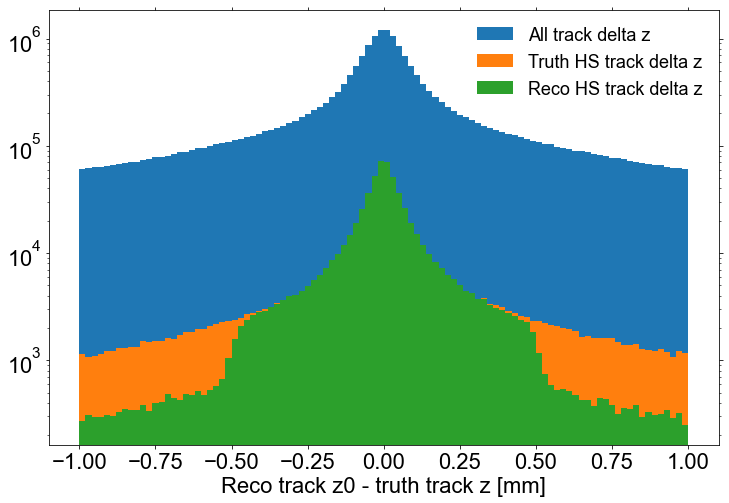

In [5]:
max_z = 1
_ = plt.hist(diff_track_z[np.abs(diff_track_z) < max_z], bins=100, label='All track delta z')
_ = plt.hist(delta_track_z_truthHS[np.abs(delta_track_z_truthHS) < max_z], bins=100, label='Truth HS track delta z')
_ = plt.hist(delta_track_z_recoHS[np.abs(delta_track_z_recoHS) < max_z], bins=100, label='Reco HS track delta z')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('Reco track z0 - truth track z [mm]')

In [6]:
# cut >1 track pT
# plot vs track eta

In [7]:
## Find truth reco link via number of shared tracks
delta_z_link_cut = 0.5

truthHS_to_reco_link_idx = []
truthHS_to_reco_link_n_shared_tracks = []

truthHS_to_reco_delta_z_cut_link_idx = []
truthHS_to_reco_delta_z_cut_link_n_shared_tracks = []
truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight = []

truthHS_to_reco_link_idx_req_HS = []
truthHS_to_reco_link_n_shared_tracks_req_HS = []

truthHS_to_reco_link_idx_req_clean = []
truthHS_to_reco_link_n_shared_tracks_req_clean = []

truthHS_to_reco_link_idx_req_cleanHS = []
truthHS_to_reco_link_n_shared_tracks_req_cleanHS = []

for event_idx in range(len(truth_vertex_t)):
    event_truth_to_reco_idx = -1
    event_truth_to_reco_n_tracks = -1

    event_truth_to_reco_delta_z_cut_idx = -1
    event_truth_to_reco_delta_z_cut_n_tracks = -1
    event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight = -1

    event_truth_to_reco_idx_req_clean = -1
    event_truth_to_reco_n_tracks_req_clean = -1

    event_truth_to_reco_idx_req_cleanHS = -1
    event_truth_to_reco_n_tracks_req_cleanHS = -1

    event_truth_to_reco_n_tracks_req_HS = -1
    event_truth_to_reco_idx_req_HS = -1

    truth_hs_track_idx = truth_vertex_track_idxs[event_idx][0]
    for i, reco_track_idxs in enumerate(reco_vertex_track_idxs[event_idx]):
        if i < 100:
            intersecting_tracks, _, reco_shared_tracks_idxs = np.intersect1d(truth_hs_track_idx, reco_track_idxs, return_indices=True)
            n = len(intersecting_tracks)
            # print(n)
            if n > event_truth_to_reco_n_tracks:
                event_reco_total_weight = np.sum(reco_vertex_track_weights[event_idx][i])
                event_reco_shared_Weight = np.sum(reco_vertex_track_weights[event_idx][i][reco_shared_tracks_idxs])

                event_truth_to_reco_idx = i
                event_truth_to_reco_n_tracks = n
                if np.abs(truth_vertex_z[event_idx][0] - reco_vertex_z[event_idx][i]) < delta_z_link_cut:
                    event_truth_to_reco_delta_z_cut_idx = i
                    event_truth_to_reco_delta_z_cut_n_tracks = n
                    event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight = event_reco_shared_Weight/event_reco_total_weight
    
    ## Require reco HS
    if event_truth_to_reco_delta_z_cut_idx == 0:
        event_truth_to_reco_idx_req_HS = 0
        event_truth_to_reco_n_tracks_req_HS = event_truth_to_reco_delta_z_cut_n_tracks
    
    if event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight > 0.7:
        event_truth_to_reco_idx_req_clean = event_truth_to_reco_delta_z_cut_idx
        event_truth_to_reco_n_tracks_req_clean = event_truth_to_reco_delta_z_cut_n_tracks
        if event_truth_to_reco_delta_z_cut_idx == 0:
            event_truth_to_reco_idx_req_cleanHS = 0
            event_truth_to_reco_n_tracks_req_cleanHS = event_truth_to_reco_delta_z_cut_n_tracks


    truthHS_to_reco_link_idx.append(event_truth_to_reco_idx)
    truthHS_to_reco_link_n_shared_tracks.append(event_truth_to_reco_n_tracks)    
    
    truthHS_to_reco_delta_z_cut_link_idx.append(event_truth_to_reco_delta_z_cut_idx)
    truthHS_to_reco_delta_z_cut_link_n_shared_tracks.append(event_truth_to_reco_delta_z_cut_n_tracks)    
    truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight.append(event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight)    
    
    truthHS_to_reco_link_idx_req_HS.append(event_truth_to_reco_idx_req_HS)
    truthHS_to_reco_link_n_shared_tracks_req_HS.append(event_truth_to_reco_n_tracks_req_HS)

    truthHS_to_reco_link_idx_req_clean.append(event_truth_to_reco_idx_req_clean)
    truthHS_to_reco_link_n_shared_tracks_req_clean.append(event_truth_to_reco_n_tracks_req_clean)

    truthHS_to_reco_link_idx_req_cleanHS.append(event_truth_to_reco_idx_req_cleanHS)
    truthHS_to_reco_link_n_shared_tracks_req_cleanHS.append(event_truth_to_reco_n_tracks_req_cleanHS)

truthHS_to_reco_link_idx = np.array(truthHS_to_reco_link_idx)
truthHS_to_reco_link_idx_req_HS = np.array(truthHS_to_reco_link_idx_req_HS)
truthHS_to_reco_delta_z_cut_link_idx = np.array(truthHS_to_reco_delta_z_cut_link_idx)
truthHS_to_reco_link_idx_req_clean = np.array(truthHS_to_reco_link_idx_req_clean)
truthHS_to_reco_link_idx_req_cleanHS = np.array(truthHS_to_reco_link_idx_req_cleanHS)

Text(0.5, 0, 'Relative reco track weight from shared tracks')

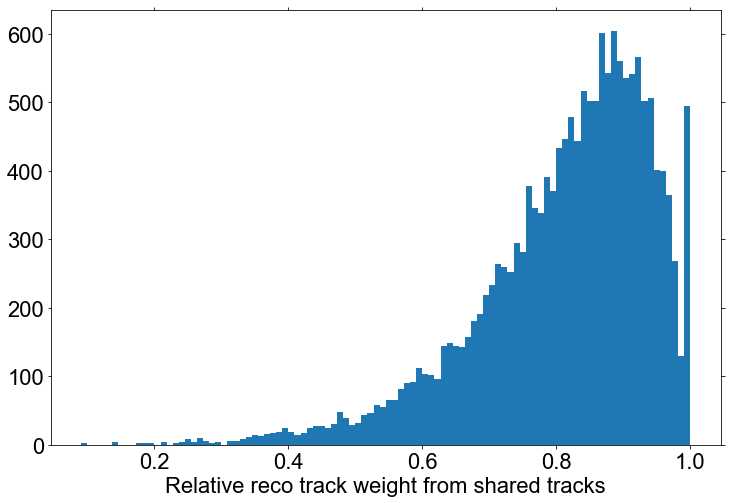

In [8]:
truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight = np.array(truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight)
plt.hist(truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight[truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight > 0], bins=100)
plt.xlabel('Relative reco track weight from shared tracks')

Text(0.5, 0, 'Reco link idx')

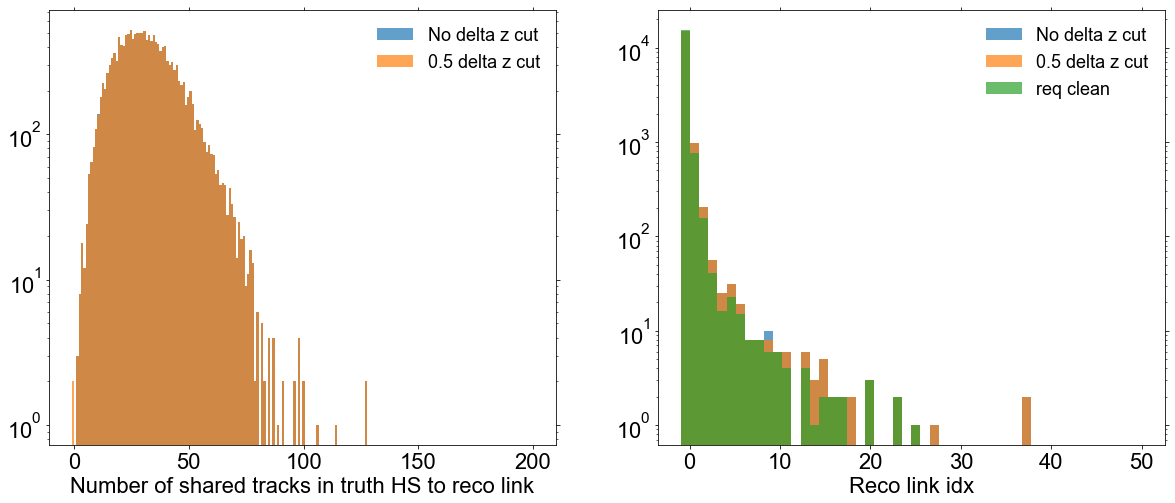

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

_ = ax1.hist(truthHS_to_reco_link_n_shared_tracks, alpha=0.7, bins=np.linspace(-1, 200, 201), label='No delta z cut')
_ = ax1.hist(truthHS_to_reco_delta_z_cut_link_n_shared_tracks, alpha=0.7, bins=np.linspace(-1, 200, 201), label='{} delta z cut'.format(delta_z_link_cut))

ax1.set_yscale('log')
ax1.legend(frameon=False)
ax1.set_xlabel('Number of shared tracks in truth HS to reco link')


_ = ax2.hist(truthHS_to_reco_link_idx, alpha=0.7, bins=np.linspace(-1, 50, 51), label='No delta z cut')
_ = ax2.hist(truthHS_to_reco_delta_z_cut_link_idx, alpha=0.7, bins=np.linspace(-1, 50, 51), label='{} delta z cut'.format(delta_z_link_cut))
_ = ax2.hist(truthHS_to_reco_link_idx_req_clean, alpha=0.7, bins=np.linspace(-1, 50, 51), label='req clean')

ax2.set_yscale('log')
ax2.legend(frameon=False)
ax2.set_xlabel('Reco link idx')

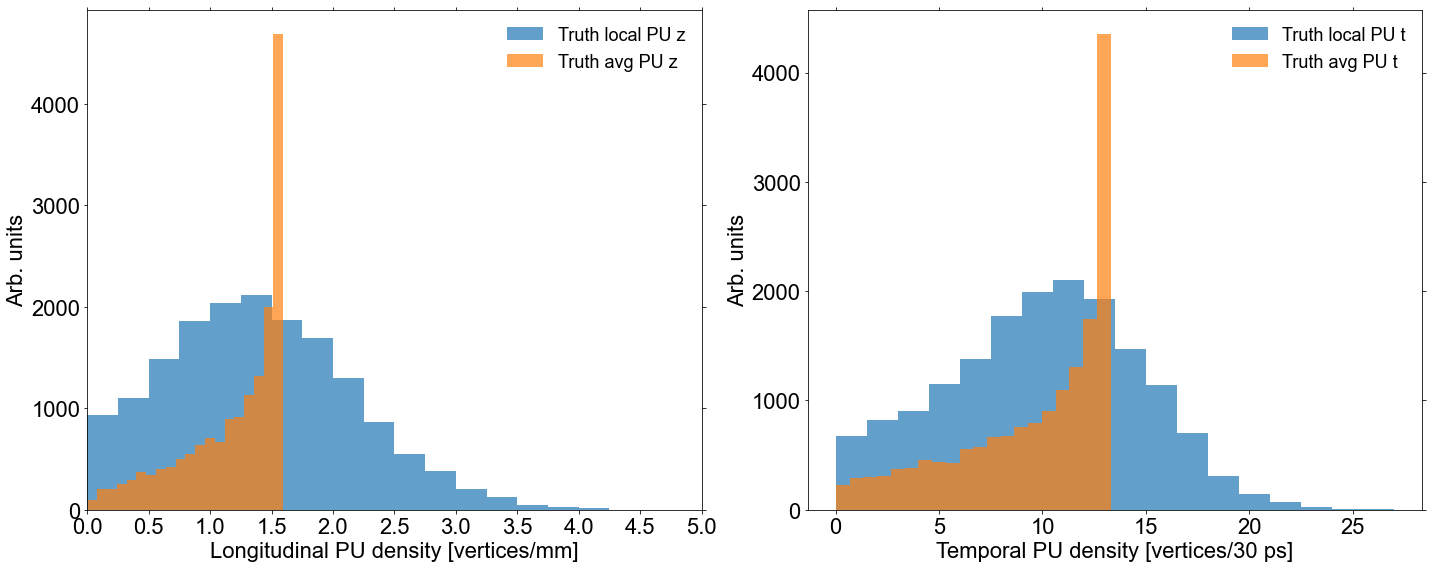

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

delta_z = 2
truth_localzPU = computeLocalPUDensity(truth_vertex_z, delta_z)
truth_avgzPU = computeAvgPUDensity(truth_vertex_z, mu=200, sigma_x=50)


zbinwidth = 1/(2*delta_z)
_, zLPU_truth_bin_edges, _ = ax1.hist(truth_localzPU, bins=np.arange(np.min(truth_localzPU), np.max(truth_localzPU) + zbinwidth, zbinwidth), density=False, alpha=0.7, label='Truth local PU z')
_, zAPU_truth_bin_edges, _ = ax1.hist(truth_avgzPU, bins=20, density=False, alpha=0.7, label='Truth avg PU z')

ax1.set_xlabel('Longitudinal PU density [vertices/mm]')
ax1.set_ylabel('Arb. units')
# ax1.set_yscale('log')
ax1.set_xticks(np.arange(0, 10, 0.5))
ax1.set_xlim(0, 5)
ax1.legend(frameon=False)


sigma_t = 180
# delta_t = 20
delta_t = 20

tPU_unit = 30
truth_localtPU = computeLocalPUDensity(1e3*truth_vertex_t/tPU_unit, delta_t/tPU_unit)
truth_avgtPU = computeAvgPUDensity(1e3*truth_vertex_t/tPU_unit, mu=200, sigma_x=sigma_t/tPU_unit)

tbinwidth = 1/(2*delta_t/tPU_unit) * 2
_, tLPU_truth_bin_edges, _ = ax2.hist(truth_localtPU, bins=np.arange(np.min(truth_localtPU), np.max(truth_localtPU) + tbinwidth, tbinwidth), density=False, alpha=0.7, label='Truth local PU t', color='C0')
_, tAPU_truth_bin_edges, _ = ax2.hist(truth_avgtPU, bins=20, density=False, alpha=0.7, label='Truth avg PU t', color='C1')

ax2.set_xlabel('Temporal PU density [vertices/{} ps]'.format(tPU_unit))
ax2.set_ylabel('Arb. units')
# ax2.set_yscale('log')
# ax2.set_xticks(np.arange(0, 0.5, 0.1))
# ax2.set_xlim(0, 0.5)
ax2.legend(frameon=False)
fig.tight_layout()

Text(0, 0.5, 'Avg time PU density')

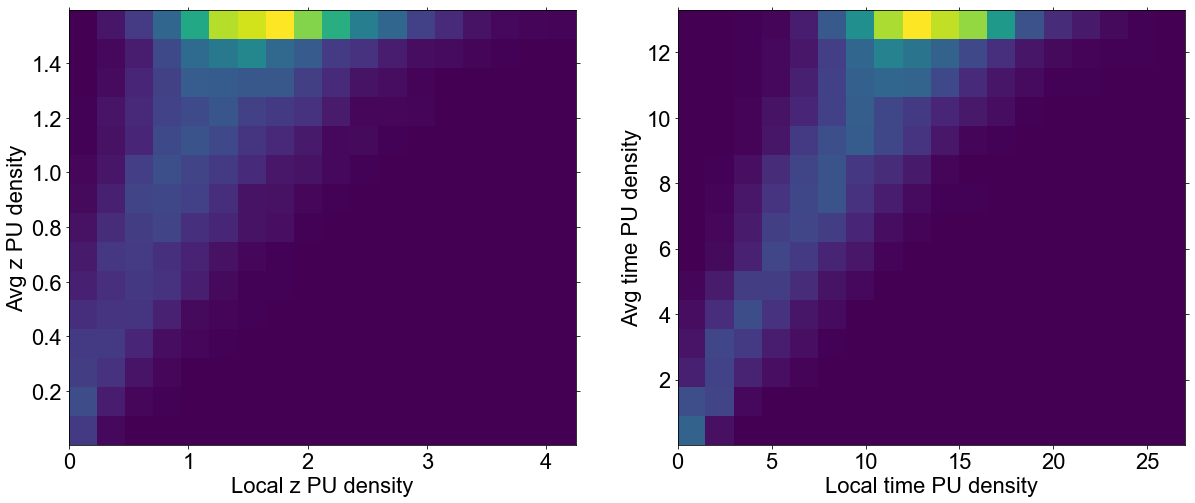

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

_  = ax1.hist2d(truth_localzPU, truth_avgzPU, bins=(18, 15))
ax1.set_xlabel('Local z PU density')
ax1.set_ylabel('Avg z PU density')

_  = ax2.hist2d(truth_localtPU, truth_avgtPU, bins=(18, 15))
ax2.set_xlabel('Local time PU density')
ax2.set_ylabel('Avg time PU density')

In [12]:
events_in_zLPU_bins = []
for bin in zLPU_truth_bin_edges:
    events_in_zLPU_bins.append(np.argwhere(np.isclose(truth_localzPU, bin)))
events_in_tLPU_bins = []
for bin in tLPU_truth_bin_edges:
    events_in_tLPU_bins.append(np.argwhere(np.isclose(truth_localtPU, bin)))

events_in_zAPU_bins = []
for i, bin in enumerate(zAPU_truth_bin_edges[1:]):
    events_in_zAPU_bins.append(np.argwhere(np.logical_and(truth_avgzPU > zAPU_truth_bin_edges[i-1], truth_avgzPU <= bin)))
events_in_tAPU_bins = []
for i, bin in enumerate(tAPU_truth_bin_edges[1:]):
    events_in_tAPU_bins.append(np.argwhere(np.logical_and(truth_avgtPU > tAPU_truth_bin_edges[i-1], truth_avgtPU <= bin)))

## TODO bin events where a hard truth vtx is close to the truth HS  

In [13]:
def n_misassociated_tracks(events_in_bins, truth_idxs, reco_idxs, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut):
    n_tracks = []
    avg_n_tracks = []
    std_n_tracks = []
    n_tracks_weight_cut = []
    avg_n_tracks_weight_cut = []
    std_n_tracks_weight_cut = []
    avg_n_wrong_tracks = []
    std_n_wrong_tracks = []
    avg_n_wrong_tracks_weight_cut = []
    std_n_wrong_tracks_weight_cut = []
    for event_idxs in events_in_bins:
        bin_n_tracks = []
        bin_n_tracks_weight_cut = []
        bin_n_wrong_tracks = []
        bin_n_wrong_tracks_weight_cut = []
        for event_idx in event_idxs:
            event_idx = event_idx[0]
            truth_idx = truth_idxs[event_idx]
            reco_idx = reco_idxs[event_idx]

            if reco_idx == -1: continue
            if truth_idx == -1: continue
            reco_n_tracks = len(reco_vertex_track_idxs[event_idx][reco_idx])
            reco_n_tracks_weight_cut = np.sum(np.array(reco_vertex_track_weights[event_idx][reco_idx]) > weight_cut)

            reco_track_idxs = reco_vertex_track_idxs[event_idx][reco_idx]
            truth_track_idxs = truth_vertex_track_idxs[event_idx][truth_idx]
            shared_tracks_idx, shared_tracks_local_reco_idxs, _ = np.intersect1d(reco_track_idxs, truth_track_idxs, return_indices=True)

            n_shared_tracks = len(shared_tracks_idx)
            n_shared_tracks_weight_cut = np.sum(np.array(reco_vertex_track_weights[event_idx][reco_idx][shared_tracks_local_reco_idxs]) > weight_cut)

            bin_n_tracks.append(reco_n_tracks)
            bin_n_tracks_weight_cut.append(reco_n_tracks_weight_cut)
            bin_n_wrong_tracks.append(reco_n_tracks - n_shared_tracks)
            bin_n_wrong_tracks_weight_cut.append(reco_n_tracks_weight_cut - n_shared_tracks_weight_cut)

        avg_n_tracks.append(np.mean(bin_n_tracks))
        std_n_tracks.append(np.std(bin_n_tracks)/np.sqrt(len(bin_n_tracks)))
        avg_n_tracks_weight_cut.append(np.mean(bin_n_tracks_weight_cut))
        std_n_tracks_weight_cut.append(np.std(bin_n_tracks_weight_cut)/np.sqrt(len(bin_n_tracks_weight_cut)))
        avg_n_wrong_tracks.append(np.mean(bin_n_wrong_tracks))
        std_n_wrong_tracks.append(np.std(bin_n_wrong_tracks, ddof=1)/np.sqrt(len(bin_n_wrong_tracks)))
        avg_n_wrong_tracks_weight_cut.append(np.mean(bin_n_wrong_tracks_weight_cut))
        std_n_wrong_tracks_weight_cut.append(np.std(bin_n_wrong_tracks_weight_cut, ddof=1)/np.sqrt(len(bin_n_wrong_tracks_weight_cut)))
    return (avg_n_tracks, std_n_tracks), (avg_n_tracks_weight_cut, std_n_tracks_weight_cut),\
         (avg_n_wrong_tracks, std_n_wrong_tracks), (avg_n_wrong_tracks_weight_cut, std_n_wrong_tracks_weight_cut)

In [14]:
weight_cut = 0.9
weight_cut2 = 0.5
# zLPU_n_misassoc_tracks_delta_z_cut = n_misassociated_tracks(events_in_zLPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
#         truthHS_to_reco_delta_z_cut_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)
# zAPU_n_misassoc_tracks_delta_z_cut = n_misassociated_tracks(events_in_zAPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
#         truthHS_to_reco_delta_z_cut_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)

zLPU_n_misassoc_tracks_w1 = n_misassociated_tracks(events_in_zLPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
        truthHS_to_reco_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)
zAPU_n_misassoc_tracks_w1 = n_misassociated_tracks(events_in_zAPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
         truthHS_to_reco_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)

zLPU_n_misassoc_tracks_w2 = n_misassociated_tracks(events_in_zLPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
        truthHS_to_reco_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut2)
zAPU_n_misassoc_tracks_w2 = n_misassociated_tracks(events_in_zAPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
         truthHS_to_reco_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut2)

zLPU_n_misassoc_tracks_w1_cleanHS = n_misassociated_tracks(events_in_zLPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
        truthHS_to_reco_link_idx_req_cleanHS, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)
zAPU_n_misassoc_tracks_w1_cleanHS = n_misassociated_tracks(events_in_zAPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
         truthHS_to_reco_link_idx_req_cleanHS, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)

zLPU_n_misassoc_tracks_w2_cleanHS = n_misassociated_tracks(events_in_zLPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
        truthHS_to_reco_link_idx_req_cleanHS, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut2)
zAPU_n_misassoc_tracks_w2_cleanHS = n_misassociated_tracks(events_in_zAPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
         truthHS_to_reco_link_idx_req_cleanHS, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut2)

# tLPU_n_misassoc_tracks_delta_z_cut = n_misassociated_tracks(events_in_tLPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
#         truthHS_to_reco_delta_z_cut_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)
# tAPU_n_misassoc_tracks_delta_z_cut = n_misassociated_tracks(events_in_tAPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
#         truthHS_to_reco_delta_z_cut_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)

# tLPU_n_misassoc_tracks = n_misassociated_tracks(events_in_tLPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
#         truthHS_to_reco_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)
# tAPU_n_misassoc_tracks = n_misassociated_tracks(events_in_tAPU_bins, np.zeros(len(truth_vertex_t), dtype=int),\
#         truthHS_to_reco_link_idx, reco_vertex_track_idxs, truth_vertex_track_idxs, reco_vertex_track_weights, weight_cut)

c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


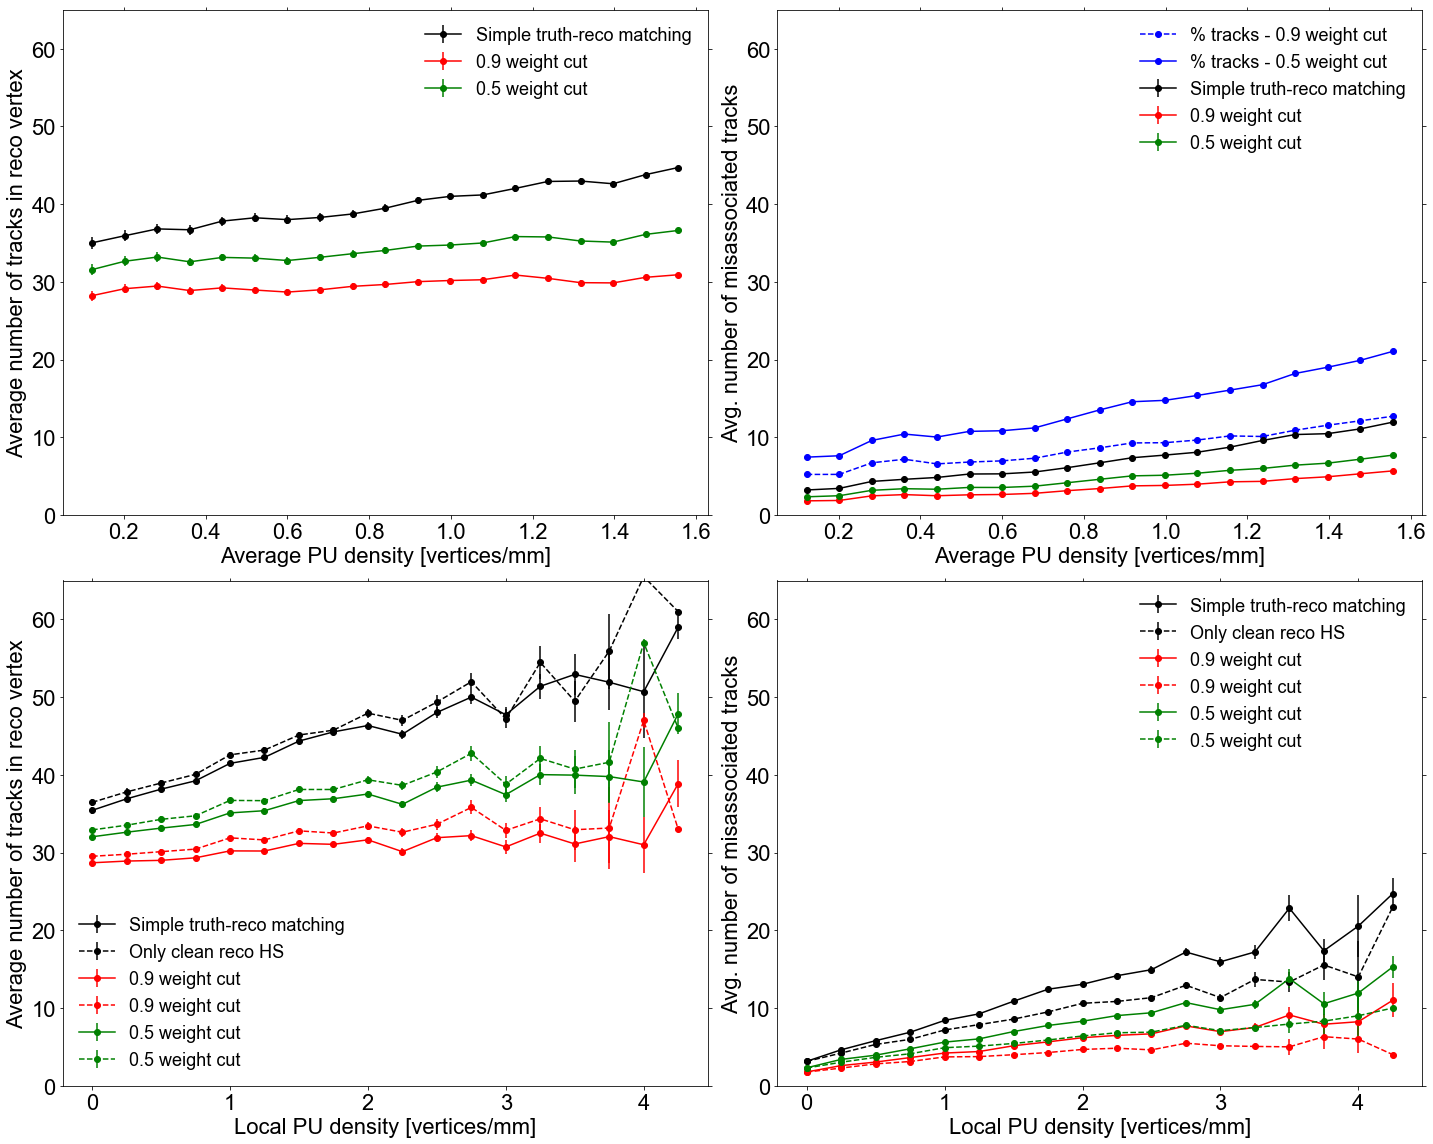

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)
bin_edges = (zAPU_truth_bin_edges[1:] - np.diff(zAPU_truth_bin_edges)/2, zLPU_truth_bin_edges)

### ax1 - avg zPU
ax1.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w1[0], fmt='ko-', label='Simple truth-reco matching')
# ax1.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w1_cleanHS[0], fmt='ko--', label='Only clean reco HS')
ax1.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w1[1], fmt='ro-', label='0.9 weight cut')
# ax1.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w1_cleanHS[1], fmt='ro--', label='0.9 weight cut')
ax1.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w2[1], fmt='go-', label='0.5 weight cut')
# ax1.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w2_cleanHS[1], fmt='go--', label='0.5 weight cut')
ax1.set_ylabel('Average number of tracks in reco vertex')
ax1.set_xlabel('Average PU density [vertices/mm]')
ax1.set_ylim(0, 65)
ax1.legend(frameon=False)

### ax3 - local zPU
ax3.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w1[0], fmt='ko-', label='Simple truth-reco matching')
ax3.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w1_cleanHS[0], fmt='ko--', label='Only clean reco HS')
ax3.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w1[1], fmt='ro-', label='0.9 weight cut')
ax3.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w1_cleanHS[1], fmt='ro--', label='0.9 weight cut')
ax3.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w2[1], fmt='go-', label='0.5 weight cut')
ax3.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w2_cleanHS[1], fmt='go--', label='0.5 weight cut')
ax3.set_ylabel('Average number of tracks in reco vertex')
ax3.set_xlabel('Local PU density [vertices/mm]')
ax3.set_ylim(0, 65)
ax3.legend(frameon=False)

### ax2 - avg zPU - misassociations
ax2.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w1[2], fmt='ko-', label='Simple truth-reco matching')
# ax2.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w1_cleanHS[2], fmt='ko--', label='Only clean reco HS')
ax2.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w1[3], fmt='ro-', label='0.9 weight cut')
ax2.plot(bin_edges[0], 100*np.array(zAPU_n_misassoc_tracks_w1[3][0])/np.array(zAPU_n_misassoc_tracks_w1[0][0]),\
                    'bo--', label='% tracks - 0.9 weight cut')
# ax2.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w1_cleanHS[3], fmt='ro--', label='0.9 weight cut')
ax2.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w2[3], fmt='go-', label='0.5 weight cut')
ax2.plot(bin_edges[0], 100*np.array(zAPU_n_misassoc_tracks_w2[3][0])/np.array(zAPU_n_misassoc_tracks_w2[1][0]),\
    'bo-', label='% tracks - 0.5 weight cut')
# ax2.errorbar(bin_edges[0], *zAPU_n_misassoc_tracks_w2_cleanHS[3], fmt='go--', label='0.5 weight cut')
ax2.set_ylabel('Avg. number of misassociated tracks')
ax2.set_xlabel('Average PU density [vertices/mm]')
ax2.set_ylim(0, 65)
ax2.legend(frameon=False)

### ax3 - local zPU - misassociations
ax4.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w1[2], fmt='ko-', label='Simple truth-reco matching')
ax4.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w1_cleanHS[2], fmt='ko--', label='Only clean reco HS')
ax4.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w1[3], fmt='ro-', label='0.9 weight cut')
ax4.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w1_cleanHS[3], fmt='ro--', label='0.9 weight cut')
ax4.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w2[3], fmt='go-', label='0.5 weight cut')
ax4.errorbar(bin_edges[1], *zLPU_n_misassoc_tracks_w2_cleanHS[3], fmt='go--', label='0.5 weight cut')
ax4.set_ylabel('Avg. number of misassociated tracks')
ax4.set_xlabel('Local PU density [vertices/mm]')
ax4.set_ylim(0, 65)
ax4.legend(frameon=False)

fig.tight_layout()

NameError: name 'zAPU_n_misassoc_tracks' is not defined

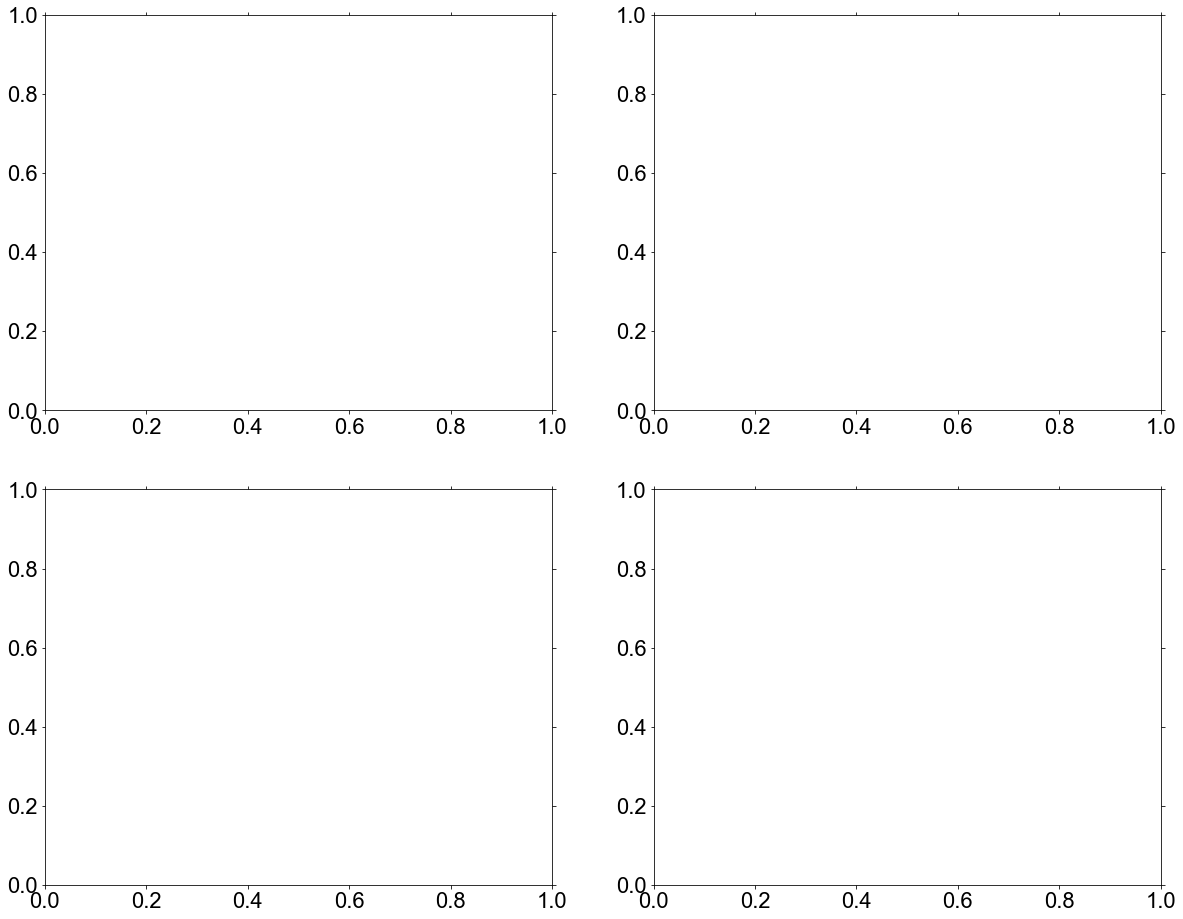

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

axes = (ax1, ax2, ax3, ax4)
all_bin_edges = (zAPU_truth_bin_edges[1:] - np.diff(zAPU_truth_bin_edges)/2, tAPU_truth_bin_edges[1:] - np.diff(tAPU_truth_bin_edges)/2, zLPU_truth_bin_edges, tLPU_truth_bin_edges)
n_misassoc_tracks_res = (zAPU_n_misassoc_tracks, tAPU_n_misassoc_tracks, zLPU_n_misassoc_tracks, tLPU_n_misassoc_tracks)
n_misassoc_tracks_delta_cut_res = (zAPU_n_misassoc_tracks_delta_z_cut, tAPU_n_misassoc_tracks_delta_z_cut, zLPU_n_misassoc_tracks_delta_z_cut, tLPU_n_misassoc_tracks_delta_z_cut)

for ax, bin_edges, n_tracks_res, n_tracks_delta_cut_res in zip(axes, all_bin_edges, n_misassoc_tracks_res, n_misassoc_tracks_delta_cut_res):
    ax.errorbar(bin_edges, *n_tracks_res[0], fmt='ro-', label='All tracks')
    ax.errorbar(bin_edges, *n_tracks_res[1], fmt='ro--', label='All tracks - {} prob cut'.format(weight_cut))
    ax.errorbar(bin_edges, *n_tracks_res[2], fmt='go-', label='Tracks from nearby vertex')
    ax.errorbar(bin_edges, *n_tracks_res[3], fmt='bo-', label='Tracks from nearby vertex - {} track prob cut'.format(weight_cut))
    ax.plot(bin_edges, np.array(n_tracks_res[2][0])/np.array(n_tracks_res[0][0])*100, 'ko-', label='% tracks from nearby vertex')
    ax.plot(bin_edges, np.array(n_tracks_res[3][0])/np.array(n_tracks_res[0][0])*100, 'ko:', label='% tracks from nearby vertex w/ prob cut')
    # ax.errorbar(bin_edges, *n_tracks_res[2], fmt='o-', label='No delta z requirement on truth reco link')
    # ax.errorbar(bin_edges, *n_tracks_delta_cut_res[2], fmt='o-', label='{} delta z requirement'.format(delta_z_link_cut))

    ax.set_ylim(-5, 80)
    ax.set_ylabel('Average number of tracks in reco vertex')
    ax.legend(frameon=False, loc='upper left')

ax1.set_xlim(0, 1.8)
ax1.set_xlabel('Avg longitudinal PU density [vertices/mm]')
ax2.set_xlim(0, 13)
ax2.set_xlabel('Avg temporal PU density [vertices/30 ps]')
ax3.set_xlim(0, 4.25)
ax3.set_xlabel('Local longitudinal PU density [vertices/mm]')
ax4.set_xlim(0, 20)
ax4.set_xlabel('Local temporal PU density [vertices/30 ps]')

fig.tight_layout()

## TODO both 0.9 0.5

In [24]:
def gaussian_no_bkg(x, ampl, mean, sd):
    return gaussian(x, ampl, mean, sd, 0)
def gaussian_fit(delta_x, sigma_0):
    ## Do a sigma cut on the data first
    n_sigma = 3
    delta_x = np.array(delta_x)[np.abs(delta_x) < n_sigma*np.std(delta_x, ddof=1)]

    # bins = np.arange(np.min(delta_x)-bin_width, np.max(delta_x)+bin_width, bin_width)
    bins = np.ceil(2*len(delta_x)**(1/3))*2
    bin_heights, bin_borders = np.histogram(delta_x, bins=int(bins))

    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

    ysigma = np.sqrt(bin_heights) + 1*(bin_heights == 0)
    p0 = (np.max(bin_heights)*0.8, 0., sigma_0)
    popt = np.array([np.nan, np.nan, np.nan])
    pcov = np.empty((3,3,))
    pcov[:] = np.nan
    try:
        popt, pcov = curve_fit(gaussian_no_bkg, bin_centers, bin_heights, sigma=ysigma, absolute_sigma=True, p0=p0)
    except:
        print('Fit failed')
    return popt, pcov

In [25]:
def basic_estimator_performance(events_in_bins, reco_idxs, truth_idxs, all_truth_z, all_reco_z, all_track_z0, all_track_z0_var, all_reco_track_idxs, all_reco_track_weights, sigma_cut):
    weighted_vs_fit_delta_z = []
    weighted_vs_fit_rms = []
    weighted_vs_fit_rms_std = []
    weighted_vs_fit_gaussian_std = []
    weighted_vs_fit_gaussian_std_std = []
    
    weighted_vs_truth_delta_z = []
    weighted_vs_truth_rms = []
    weighted_vs_truth_rms_std = []

    weighted_vs_fit_delta_z_sigma_cut = []
    weighted_vs_fit_rms_sigma_cut = []
    weighted_vs_fit_rms_std_sigma_cut = []
    
    for event_idxs in events_in_bins:
        bin_weighted_vs_fit_delta_z = []
        bin_weighted_vs_truth_delta_z = []
        for event_idx in event_idxs:
            event_idx = event_idx[0]
            reco_idx = reco_idxs[event_idx]
            truth_idx = truth_idxs[event_idx]
            if reco_idx == -1: continue
            if truth_idx == -1: continue

            reco_track_z0 = all_track_z0[event_idx][all_reco_track_idxs[event_idx][reco_idx]]
            reco_track_z0_var = np.array(all_track_z0_var[event_idx][all_reco_track_idxs[event_idx][reco_idx]])
            reco_track_weights = np.array(all_reco_track_weights[event_idx][reco_idx])

            weighted_reco_z = np.average(reco_track_z0, weights=reco_track_weights/reco_track_z0_var)
            bin_weighted_vs_fit_delta_z.append(weighted_reco_z - all_reco_z[event_idx][reco_idx])
            bin_weighted_vs_truth_delta_z.append(weighted_reco_z - all_truth_z[event_idx][truth_idx])
        weighted_vs_fit_delta_z.append(np.array(bin_weighted_vs_fit_delta_z))
        weighted_vs_truth_delta_z.append(np.array(bin_weighted_vs_truth_delta_z))

        weighted_vs_fit_rms.append(np.sqrt(np.mean(np.array(bin_weighted_vs_fit_delta_z)**2)))
        # weighted_vs_fit_rms.append(np.std(bin_weighted_vs_fit_delta_z, ddof=1))
        weighted_vs_truth_rms.append(np.sqrt(np.mean(np.array(bin_weighted_vs_truth_delta_z)**2)))
        # weighted_vs_truth_rms.append(np.std(bin_weighted_vs_truth_delta_z, ddof=1))
        
        weighted_vs_fit_rms_std.append(bootstrap_rms_std(bin_weighted_vs_fit_delta_z))
        # weighted_vs_fit_rms_std.append(bootstrap_std_std(bin_weighted_vs_fit_delta_z))
        weighted_vs_truth_rms_std.append(bootstrap_rms_std(bin_weighted_vs_truth_delta_z))
        # weighted_vs_truth_rms_std.append(bootstrap_std_std(bin_weighted_vs_truth_delta_z))

        ## sigma cutting
        weighted_vs_fit_delta_z_sigma = np.std(bin_weighted_vs_fit_delta_z, ddof=1)
        bin_weighted_vs_fit_delta_z_sigma_cut = np.array(bin_weighted_vs_fit_delta_z)[np.abs(bin_weighted_vs_fit_delta_z) < sigma_cut*weighted_vs_fit_delta_z_sigma]
        weighted_vs_fit_delta_z_sigma_cut.append(bin_weighted_vs_fit_delta_z_sigma_cut)
        
        weighted_vs_fit_rms_sigma_cut.append(np.sqrt(np.mean(np.array(bin_weighted_vs_fit_delta_z_sigma_cut)**2)))
        # weighted_vs_fit_rms_sigma_cut.append(np.std(bin_weighted_vs_fit_delta_z_sigma_cut, ddof=1))
        weighted_vs_fit_rms_std_sigma_cut.append(bootstrap_rms_std(bin_weighted_vs_fit_delta_z_sigma_cut))
        # weighted_vs_fit_rms_std_sigma_cut.append(bootstrap_std_std(bin_weighted_vs_fit_delta_z_sigma_cut))

        if len(bin_weighted_vs_fit_delta_z) >= 4:
            popt, pcov = gaussian_fit(bin_weighted_vs_fit_delta_z, 10e-3)
            weighted_vs_fit_gaussian_std.append(popt[2])
            weighted_vs_fit_gaussian_std_std.append(pcov[2,2]**0.5)
        else:
            weighted_vs_fit_gaussian_std.append(np.nan)
            weighted_vs_fit_gaussian_std_std.append(np.nan)
    return {
        'weighted_vs_fit_delta_z'   : np.array(weighted_vs_fit_delta_z),
        'weighted_vs_truth_delta_z' : np.array(weighted_vs_truth_delta_z),
        'weighted_vs_fit_rms'       : np.array(weighted_vs_fit_rms),
        'weighted_vs_fit_gaussian_std' : np.array(weighted_vs_fit_gaussian_std),
        'weighted_vs_fit_gaussian_std_std' : np.array(weighted_vs_fit_gaussian_std_std),
        'weighted_vs_truth_rms'     : np.array(weighted_vs_truth_rms),
        'weighted_vs_fit_rms_std'   : np.array(weighted_vs_fit_rms_std),
        'weighted_vs_truth_rms_std' : np.array(weighted_vs_truth_rms_std),
        'weighted_vs_fit_delta_z_sigma_cut' : np.array(weighted_vs_fit_delta_z_sigma_cut),
        'weighted_vs_fit_rms_sigma_cut' : np.array(weighted_vs_fit_rms_sigma_cut),
        'weighted_vs_fit_rms_std_sigma_cut' : np.array(weighted_vs_fit_rms_std_sigma_cut),
    }

In [26]:
sigma_cut = 2
zLPU_estimator_performance = basic_estimator_performance(events_in_zLPU_bins, truthHS_to_reco_delta_z_cut_link_idx, np.zeros(len(truth_vertex_t), dtype=int),\
    truth_vertex_z, reco_vertex_z, track_z0, track_z0_var, reco_vertex_track_idxs, reco_vertex_track_weights, sigma_cut)

zLPU_estimator_performance_cleanHS = basic_estimator_performance(events_in_zLPU_bins, truthHS_to_reco_link_idx_req_cleanHS, np.zeros(len(truth_vertex_t), dtype=int),\
    truth_vertex_z, reco_vertex_z, track_z0, track_z0_var, reco_vertex_track_idxs, reco_vertex_track_weights, sigma_cut)

zAPU_estimator_performance = basic_estimator_performance(events_in_zAPU_bins, truthHS_to_reco_delta_z_cut_link_idx, np.zeros(len(truth_vertex_t), dtype=int),\
    truth_vertex_z, reco_vertex_z, track_z0, track_z0_var, reco_vertex_track_idxs, reco_vertex_track_weights, sigma_cut)

zAPU_estimator_performance_cleanHS = basic_estimator_performance(events_in_zAPU_bins, truthHS_to_reco_link_idx_req_cleanHS, np.zeros(len(truth_vertex_t), dtype=int),\
    truth_vertex_z, reco_vertex_z, track_z0, track_z0_var, reco_vertex_track_idxs, reco_vertex_track_weights, sigma_cut)

Fit failed


c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

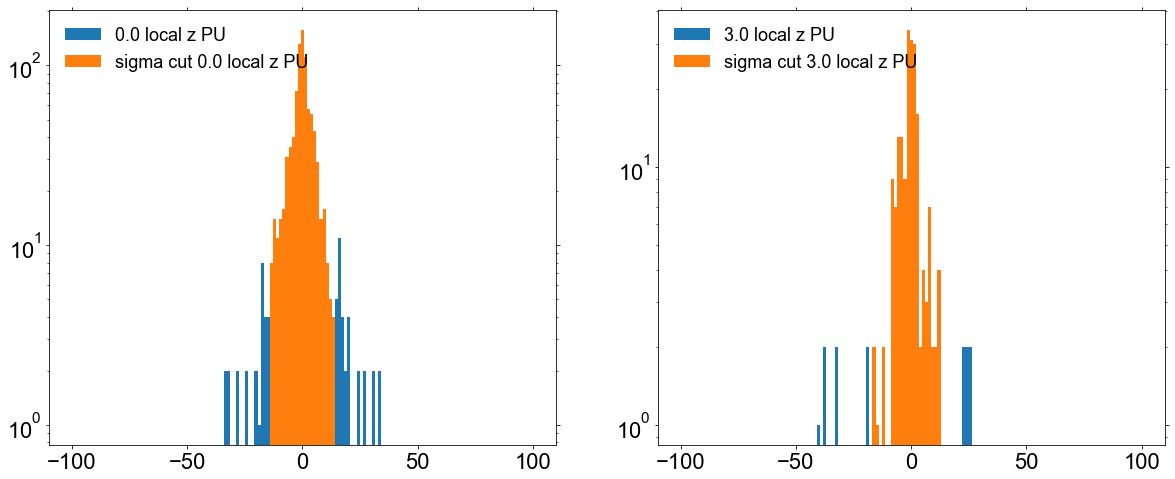

In [ ]:
high_pu_bin = -6
low_pu_bin = 0
bins = np.linspace(-100, 100, 150)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

_ = ax1.hist(1e3*zLPU_estimator_performance['weighted_vs_fit_delta_z'][low_pu_bin]  , bins=bins, label='{} local z PU'.format(zLPU_truth_bin_edges[low_pu_bin]))
_ = ax1.hist(1e3*zLPU_estimator_performance['weighted_vs_fit_delta_z_sigma_cut'][low_pu_bin]  , bins=bins, label='sigma cut {} local z PU'.format(zLPU_truth_bin_edges[low_pu_bin]))

_ = ax2.hist(1e3*zLPU_estimator_performance['weighted_vs_fit_delta_z'][high_pu_bin], bins=bins, label='{} local z PU'.format(zLPU_truth_bin_edges[high_pu_bin]))
_ = ax2.hist(1e3*zLPU_estimator_performance['weighted_vs_fit_delta_z_sigma_cut'][high_pu_bin], bins=bins, label='sigma cut {} local z PU'.format(zLPU_truth_bin_edges[high_pu_bin]))
ax1.legend(frameon=False, loc='upper left')
ax2.legend(frameon=False, loc='upper left')
ax1.set_yscale('log')
ax2.set_yscale('log')

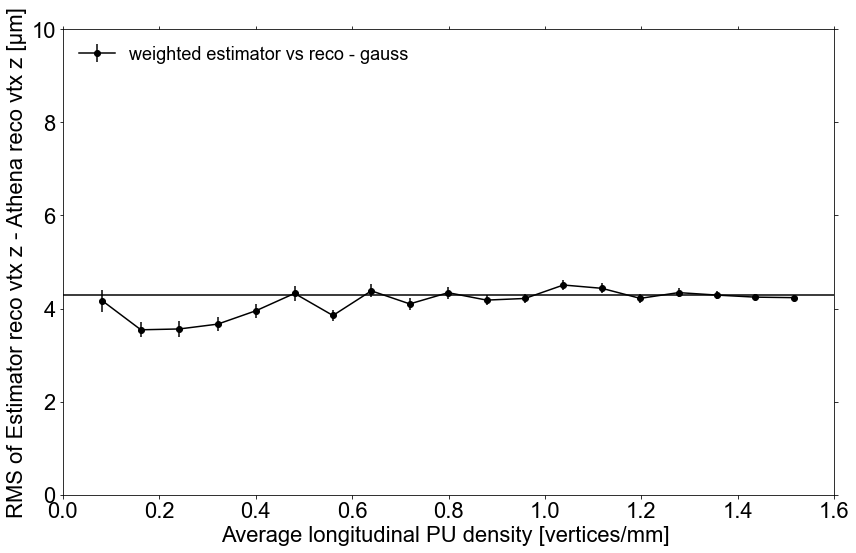

In [37]:
# fig, (ax1, ax2) = plt.subplots(2, 1)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

# ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges), 1e3*zAPU_estimator_performance['weighted_vs_fit_rms'], 1e3*zAPU_estimator_performance['weighted_vs_fit_rms_std'], \
#             fmt='ko-', label='weighted estimator vs reco')
# ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges), 1e3*zAPU_estimator_performance['weighted_vs_fit_rms_sigma_cut'], \
#     1e3*zAPU_estimator_performance['weighted_vs_fit_rms_std_sigma_cut'], fmt='ko--', label='{} sigma cut weighted estimator vs reco'.format(sigma_cut))

ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges), 1e3*zAPU_estimator_performance['weighted_vs_fit_gaussian_std'],\
    1e3*zAPU_estimator_performance['weighted_vs_fit_gaussian_std_std'], \
            fmt='ko-', label='weighted estimator vs reco - gauss')

# ax2.errorbar(zLPU_truth_bin_edges, 1e3*zLPU_estimator_performance['weighted_vs_fit_rms'], 1e3*zLPU_estimator_performance['weighted_vs_fit_rms_std'], \
#             fmt='ko-', label='weighted estimator vs reco')
# ax2.errorbar(zLPU_truth_bin_edges, 1e3*zLPU_estimator_performance['weighted_vs_fit_rms_sigma_cut'], \
#     1e3*zLPU_estimator_performance['weighted_vs_fit_rms_std_sigma_cut'], fmt='ko--', label='{} sigma cut weighted estimator vs reco'.format(sigma_cut))

# ax2.errorbar(zLPU_truth_bin_edges, 1e3*zLPU_estimator_performance['weighted_vs_fit_gaussian_std'],\
#     1e3*zLPU_estimator_performance['weighted_vs_fit_gaussian_std_std'], \
#         fmt='ko-', label='weighted estimator vs reco - gauss')

ax1.hlines(4.3, 0, 1.6)
ax1.set_xlim(0, 1.6)
ax1.set_ylim(0, 10)
ax1.set_xlabel('Average longitudinal PU density [vertices/mm] ')
ax1.set_ylabel('RMS of Estimator reco vtx z - Athena reco vtx z [µm]')
ax1.legend(frameon=False, loc='upper left')

# ax2.set_xlim(0, 3.5)
# ax2.set_ylim(0, 10)
# ax2.set_xlabel('Local longitudinal PU density [vertices/mm] ')
# ax2.set_ylabel('RMS of Estimator reco vtx z - Athena reco vtx z [µm]')
# ax2.legend(frameon=False, loc='upper left')
fig.tight_layout()

# plt.errorbar(zLPU_truth_bin_edges, 1e3*zLPU_estimator_performance['weighted_vs_truth_rms'], 1e3*zLPU_estimator_performance['weighted_vs_truth_rms_std'], \
#             fmt='ro-', label='weighted estimator vs truth')

In [38]:
def athena_performance(events_in_bins, all_truth_idxs, all_reco_idxs, all_truth_z, all_reco_z, sigma_cut):
    delta_z = []
    delta_z_rms = []
    delta_z_rms_std = []
    delta_z_sigma_cut = []
    delta_z_rms_sigma_cut = []
    delta_z_rms_std_sigma_cut = []
    gaussian_std = []
    gaussian_std_std = []
    
    for event_idxs in events_in_bins:
        bin_delta_z = []
        for event_idx in event_idxs:
            event_idx = event_idx[0]
            reco_idx = all_reco_idxs[event_idx]
            truth_idx = all_truth_idxs[event_idx]
            if reco_idx == -1: continue
            if truth_idx == -1: continue

            event_reco_z = all_reco_z[event_idx][reco_idx]
            event_truth_z = all_truth_z[event_idx][truth_idx]

            bin_delta_z.append(event_reco_z - event_truth_z)

        delta_z.append(np.array(bin_delta_z))
        delta_z_rms.append(np.std(bin_delta_z, ddof=1))
        delta_z_rms_std.append(bootstrap_std_std(bin_delta_z))

        ## sigma cut
        bin_delta_z_sigma = np.std(bin_delta_z, ddof=1)
        bin_delta_z_sigma_cut = np.array(bin_delta_z)[bin_delta_z < sigma_cut*bin_delta_z_sigma]
        delta_z_sigma_cut.append(bin_delta_z_sigma_cut)
        delta_z_rms_sigma_cut.append(np.std(bin_delta_z_sigma_cut, ddof=1))
        delta_z_rms_std_sigma_cut.append(bootstrap_std_std(bin_delta_z_sigma_cut))

        if len(bin_delta_z) >= 4:
            popt, pcov = gaussian_fit(bin_delta_z, 12e-3)
            gaussian_std.append(popt[2])
            gaussian_std_std.append(pcov[2,2]**0.5)
        else:
            gaussian_std.append(np.nan)
            gaussian_std_std.append(np.nan)

    return {
        'delta_z' : delta_z,
        'delta_z_rms' : delta_z_rms,
        'delta_z_rms_std' : delta_z_rms_std,
        'delta_z_sigma_cut' : delta_z_sigma_cut,
        'delta_z_rms_sigma_cut' : delta_z_rms_sigma_cut,
        'delta_z_rms_std_sigma_cut' : delta_z_rms_std_sigma_cut,
        'gaussian_std' : gaussian_std,
        'gaussian_std_std' : gaussian_std_std,
    }

In [39]:
zLPU_athena_perf = athena_performance(events_in_zLPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_z, reco_vertex_z, 2)
tLPU_athena_perf = athena_performance(events_in_tLPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_z, reco_vertex_z, 2)
zAPU_athena_perf = athena_performance(events_in_zAPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_z, reco_vertex_z, 2)
tAPU_athena_perf = athena_performance(events_in_tAPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_z, reco_vertex_z, 2)

<ipython-input-38-ca9027c9ae41>:39: RuntimeWarning: invalid value encountered in double_scalars
  gaussian_std_std.append(pcov[2,2]**0.5)
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [41]:
zLPU_athena_perf_req_clean = athena_performance(events_in_zLPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_clean,\
    truth_vertex_z, reco_vertex_z, 2)
tLPU_athena_perf_req_clean = athena_performance(events_in_tLPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_clean,\
    truth_vertex_z, reco_vertex_z, 2)
zAPU_athena_perf_req_clean = athena_performance(events_in_zAPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_clean,\
    truth_vertex_z, reco_vertex_z, 2)
tAPU_athena_perf_req_clean = athena_performance(events_in_tAPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_clean,\
    truth_vertex_z, reco_vertex_z, 2)

Fit failed


<ipython-input-38-ca9027c9ae41>:39: RuntimeWarning: invalid value encountered in double_scalars
  gaussian_std_std.append(pcov[2,2]**0.5)


Fit failed


In [42]:
zLPU_athena_perf_req_cleanHS = athena_performance(events_in_zLPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_cleanHS,\
    truth_vertex_z, reco_vertex_z, 2)
tLPU_athena_perf_req_cleanHS = athena_performance(events_in_tLPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_cleanHS,\
    truth_vertex_z, reco_vertex_z, 2)
zAPU_athena_perf_req_cleanHS = athena_performance(events_in_zAPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_cleanHS,\
    truth_vertex_z, reco_vertex_z, 2)
tAPU_athena_perf_req_cleanHS = athena_performance(events_in_tAPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_cleanHS,\
    truth_vertex_z, reco_vertex_z, 2)

Fit failed


<ipython-input-38-ca9027c9ae41>:39: RuntimeWarning: invalid value encountered in double_scalars
  gaussian_std_std.append(pcov[2,2]**0.5)


Fit failed


In [43]:
zLPU_athena_perf_link_req_HS = athena_performance(events_in_zLPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_HS,\
    truth_vertex_z, reco_vertex_z, 2)
tLPU_athena_perf_link_req_HS = athena_performance(events_in_tLPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_HS,\
    truth_vertex_z, reco_vertex_z, 2)
zAPU_athena_perf_link_req_HS = athena_performance(events_in_zAPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_HS,\
    truth_vertex_z, reco_vertex_z, 2)
tAPU_athena_perf_link_req_HS = athena_performance(events_in_tAPU_bins, np.zeros(len(truth_vertex_z), dtype=int), truthHS_to_reco_link_idx_req_HS,\
    truth_vertex_z, reco_vertex_z, 2)

<ipython-input-38-ca9027c9ae41>:39: RuntimeWarning: invalid value encountered in double_scalars
  gaussian_std_std.append(pcov[2,2]**0.5)


In [44]:
def vtx_z_info(events_in_bins, truth_vtx_idx_in_bins, all_truth_vtx_z, reco_vtx_idx_in_bins, all_reco_track_idxs, all_reco_track_weights, all_track_z0, all_track_z0_var, sigma_cut, weight_cut):
    track_delta_z = []
    track_delta_z_rms = []
    
    track_weight_cut_delta_z = []
    track_weight_cut_delta_z_rms = []
    
    track_sigma_cut_delta_z = []
    track_sigma_cut_delta_z_rms = []
    
    track_vtx_z_res = []
    track_vtx_z_res_weight_cut = []
    track_vtx_z_res_sigma_cut = []
    track_vtx_z_res_std = []
    track_vtx_z_res_std_weight_cut = []
    track_vtx_z_res_std_sigma_cut = []
    
    vtx_delta_z = []
    vtx_weighted_delta_z = []
    vtx_weight_cut_delta_z = []
    vtx_sigma_cut_weighted_delta_z = []
    
    vtx_z_res = []
    vtx_weighted_z_res = []
    vtx_weight_cut_z_res = []
    vtx_weight_cut_weighted_z_res = []
    vtx_sigma_cut_weighted_z_res = []
    vtx_z_res_tracks_sigma_cut = []
    vtx_weighted_z_res_tracks_sigma_cut = []

    vtx_z_res_std = []
    vtx_weighted_z_res_std = []
    vtx_weight_cut_z_res_std = []
    vtx_weight_cut_weighted_z_res_std = []
    vtx_sigma_cut_weighted_z_res_std = []
    vtx_z_res_std_tracks_sigma_cut = []
    vtx_weighted_z_res_std_tracks_sigma_cut = []

    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs, truth_vtx_idxs, reco_vtx_idxs in zip(events_in_bins, truth_vtx_idx_in_bins, reco_vtx_idx_in_bins):
        bin_track_delta_z = np.array([])
        bin_track_delta_z_rms = []
        
        bin_vtx_delta_z = []
        bin_vtx_weighted_delta_z = []
        
        bin_track_weight_cut_delta_z = np.array([])
        bin_track_weight_cut_delta_z_rms = []
        
        bin_vtx_weight_cut_delta_z = []
        bin_vtx_weight_cut_weighted_delta_z = []
        
        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            if reco_idx == -1: continue
            if truth_idx == -1: continue

            idx = idx[0]
            reco_track_z = all_track_z0[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_z_var = all_track_z0_var[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_weights = all_reco_track_weights[idx][reco_idx]
            bin_reco_n_tracks.append(len(reco_track_z))
            
            truth_z = all_truth_vtx_z[idx][truth_idx]
            event_track_delta_z = reco_track_z - truth_z
            
            bin_track_delta_z = np.concatenate((bin_track_delta_z, event_track_delta_z))
            bin_track_delta_z_rms.append(np.sqrt(np.mean(event_track_delta_z**2)))
            
            reco_vtx_z = np.mean(reco_track_z)
            reco_vtx_weighted_z = np.average(reco_track_z, weights=reco_track_weights/reco_track_z_var)
            
            bin_vtx_delta_z.append(reco_vtx_z - truth_z)
            bin_vtx_weighted_delta_z.append(reco_vtx_weighted_z - truth_z)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            if np.sum(weight_cut_idx) > 0:
                weight_cut_track_z = reco_track_z[weight_cut_idx]
                bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_z))
                
                weight_cut_event_delta_z = weight_cut_track_z - truth_z
            
                bin_track_weight_cut_delta_z = np.concatenate((bin_track_weight_cut_delta_z, weight_cut_event_delta_z))
                bin_track_weight_cut_delta_z_rms.append(np.sqrt(np.mean(weight_cut_event_delta_z**2)))
                
                weight_cut_vtx_z = np.mean(weight_cut_track_z)
                weight_cut_vtx_weighted_z = np.average(weight_cut_track_z, weights = reco_track_weights[weight_cut_idx]/reco_track_z_var[weight_cut_idx])
                
                bin_vtx_weight_cut_delta_z.append(weight_cut_vtx_z - truth_z)
                bin_vtx_weight_cut_weighted_delta_z.append(weight_cut_vtx_weighted_z - truth_z)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_z.append(bin_track_delta_z)
        track_delta_z_rms.append(bin_track_delta_z_rms)
        track_weight_cut_delta_z.append(bin_track_weight_cut_delta_z)
        track_weight_cut_delta_z_rms.append(bin_track_weight_cut_delta_z_rms)
        
        track_vtx_z_res.append(np.mean(bin_track_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_z_res_std.append(np.std(bin_track_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks)), ddof=1)/np.sqrt(len(bin_reco_n_tracks)))
        track_vtx_z_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        track_vtx_z_res_std_weight_cut.append(np.std(bin_track_weight_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut)), ddof=1)/np.sqrt(len(bin_track_weight_cut_delta_z_rms)))
        
        
        vtx_delta_z.append(bin_vtx_delta_z)
        vtx_weighted_delta_z.append(bin_vtx_weighted_delta_z)
        vtx_weight_cut_delta_z.append(bin_vtx_weight_cut_delta_z)
        
        vtx_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z)**2)))
        vtx_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z)**2)))
        vtx_weight_cut_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_z)**2)))
        vtx_weight_cut_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_z)**2)))
        
        # Sigma cutting on vtx delta z distribution
        bin_vtx_weighted_delta_z_sigma = np.std(bin_vtx_weighted_delta_z, ddof=1)
        bin_vtx_delta_z_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_z - np.mean(bin_vtx_weighted_delta_z)) < sigma_cut*bin_vtx_weighted_delta_z_sigma
        vtx_sigma_cut_weighted_delta_z.append(np.array(bin_vtx_weighted_delta_z)[bin_vtx_delta_z_sigma_cut_idxs])
        vtx_sigma_cut_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z)[bin_vtx_delta_z_sigma_cut_idxs]**2)))
        
        
        ## Sigma cutting on tracks both for track based estimate on vtx z res and estimator of vtx z 
        bin_track_sigma = np.std(bin_track_delta_z)
        bin_track_sigma_cut_delta_z = np.array([])
        bin_track_sigma_cut_delta_z_rms = []
        bin_reco_n_tracks_sigma_cut = []
        
        bin_vtx_delta_z_tracks_sigma_cut = []
        bin_vtx_weighted_delta_z_tracks_sigma_cut = []
        
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            if reco_idx == -1: continue
            if truth_idx == -1: continue

            idx = idx[0]
            reco_track_z = all_track_z0[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_z_var = all_track_z0_var[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_weights = all_reco_track_weights[idx][reco_idx]
            
            truth_z = all_truth_vtx_z[idx][truth_idx]
            event_track_delta_z = reco_track_z - truth_z
            
            track_sigma_cut_idx = np.abs(event_track_delta_z - np.mean(event_track_delta_z)) < sigma_cut*bin_track_sigma
            event_track_delta_z_sigma_cut = event_track_delta_z[track_sigma_cut_idx]
            
            bin_track_sigma_cut_delta_z = np.concatenate((bin_track_sigma_cut_delta_z, event_track_delta_z_sigma_cut))
            bin_track_sigma_cut_delta_z_rms.append(np.sqrt(np.mean(event_track_delta_z_sigma_cut**2)))
            bin_reco_n_tracks_sigma_cut.append(len(event_track_delta_z_sigma_cut))
            
            reco_vtx_z_sigma_cut_tracks = np.mean(reco_track_z[track_sigma_cut_idx])
            reco_vtx_weighted_z_sigma_cut_tracks = np.average(reco_track_z[track_sigma_cut_idx], weights=reco_track_weights[track_sigma_cut_idx]/reco_track_z_var[track_sigma_cut_idx])
            
            bin_vtx_delta_z_tracks_sigma_cut.append(reco_vtx_z_sigma_cut_tracks - truth_z)
            bin_vtx_weighted_delta_z_tracks_sigma_cut.append(reco_vtx_weighted_z_sigma_cut_tracks - truth_z)
        
        track_sigma_cut_delta_z.append(bin_track_sigma_cut_delta_z)
        track_sigma_cut_delta_z_rms.append(bin_track_sigma_cut_delta_z_rms)
        track_vtx_z_res_sigma_cut.append(np.mean(bin_track_sigma_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_sigma_cut))))
        track_vtx_z_res_std_sigma_cut.append(np.std(bin_track_sigma_cut_delta_z_rms / np.sqrt(np.array(bin_reco_n_tracks_sigma_cut)), ddof=1)/np.sqrt(len(bin_reco_n_tracks_sigma_cut)))
        
        vtx_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z_tracks_sigma_cut)**2)))
        vtx_weighted_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z_tracks_sigma_cut)**2)))
        
        # Compute bootstrap std deviations
        bootstrap_vtx_z_res = []
        bootstrap_vtx_weighted_z_res = []
        bootstrap_vtx_weight_cut_z_res = []
        bootstrap_vtx_weight_cut_weighted_z_res = []
        bootstrap_vtx_sigma_cut_weighted_z_res = []

        bootstrap_vtx_z_res_tracks_sigma_cut = []
        bootstrap_vtx_weighted_z_res_tracks_sigma_cut = []
        for _ in range(int(1e3)):
            bin_vtx_delta_z_idx = np.random.randint(0, len(bin_vtx_delta_z), len(bin_vtx_delta_z))
            bootstrap_vtx_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z)[bin_vtx_delta_z_idx]**2)))
            
            bin_vtx_weighted_delta_z_idx = np.random.randint(0, len(bin_vtx_weighted_delta_z), len(bin_vtx_weighted_delta_z))
            bootstrap_vtx_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z)[bin_vtx_weighted_delta_z_idx]**2)))
            
            bin_vtx_weight_cut_delta_z_idx = np.random.randint(0, len(bin_vtx_weight_cut_delta_z), len(bin_vtx_weight_cut_delta_z))
            bootstrap_vtx_weight_cut_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_z)[bin_vtx_weight_cut_delta_z_idx]**2)))
            
            bin_vtx_weight_cut_weighted_delta_z_idx = np.random.randint(0, len(bin_vtx_weight_cut_weighted_delta_z), len(bin_vtx_weight_cut_weighted_delta_z))
            bootstrap_vtx_weight_cut_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_z)[bin_vtx_weight_cut_weighted_delta_z_idx]**2)))

            ## Sigma cut on vtx weighted z distribution 
            bin_vtx_sigma_cut_weighted_delta_z_idx = np.random.randint(0, np.sum(bin_vtx_delta_z_sigma_cut_idxs), np.sum(bin_vtx_delta_z_sigma_cut_idxs))
            bootstrap_vtx_sigma_cut_weighted_z_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_z)[bin_vtx_delta_z_sigma_cut_idxs][bin_vtx_sigma_cut_weighted_delta_z_idx]**2)))

            bin_vtx_delta_z_tracks_sigma_cut_idx = np.random.randint(0, len(bin_vtx_delta_z_tracks_sigma_cut), len(bin_vtx_delta_z_tracks_sigma_cut))
            bootstrap_vtx_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z_tracks_sigma_cut)[bin_vtx_delta_z_tracks_sigma_cut_idx]**2)))
            
            bin_vtx_weighted_delta_z_tracks_sigma_cut_idx = np.random.randint(0, len(bin_vtx_weighted_delta_z_tracks_sigma_cut), len(bin_vtx_weighted_delta_z_tracks_sigma_cut))
            bootstrap_vtx_weighted_z_res_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_delta_z_tracks_sigma_cut)[bin_vtx_weighted_delta_z_tracks_sigma_cut_idx]**2)))
        
        vtx_z_res_std.append(np.std(bootstrap_vtx_z_res, ddof=1))
        vtx_weighted_z_res_std.append(np.std(bootstrap_vtx_weighted_z_res, ddof=1))
        vtx_weight_cut_z_res_std.append(np.std(bootstrap_vtx_weight_cut_z_res, ddof=1))
        vtx_weight_cut_weighted_z_res_std.append(np.std(bootstrap_vtx_weight_cut_weighted_z_res, ddof=1))
        vtx_sigma_cut_weighted_z_res_std.append(np.std(bootstrap_vtx_sigma_cut_weighted_z_res, ddof=1))
        vtx_z_res_std_tracks_sigma_cut.append(np.std(bootstrap_vtx_z_res_tracks_sigma_cut, ddof=1))
        vtx_weighted_z_res_std_tracks_sigma_cut.append(np.std(bootstrap_vtx_weighted_z_res_tracks_sigma_cut, ddof=1))
        
        
    return  {
                'avg_n_tracks' : avg_n_tracks,
                'avg_n_tracks_weight_cut' : avg_n_tracks_weight_cut,
                'track_delta_z' : track_delta_z,
                'track_delta_z_rms' : track_delta_z_rms,
                'track_weight_cut_delta_z' : track_weight_cut_delta_z,
                'track_weight_cut_delta_z_rms' : track_weight_cut_delta_z_rms,
                'track_sigma_cut_delta_z' : track_sigma_cut_delta_z,
                'track_sigma_cut_delta_z_rms' : track_sigma_cut_delta_z_rms,
                'track_vtx_z_res' : track_vtx_z_res,
                'track_vtx_z_res_weight_cut' : track_vtx_z_res_weight_cut,
                'track_vtx_z_res_sigma_cut' : track_vtx_z_res_sigma_cut,
                'vtx_delta_z' : vtx_delta_z,
                'vtx_weighted_delta_z' : vtx_weighted_delta_z,
                'vtx_weight_cut_delta_z' : vtx_weight_cut_delta_z,
                'vtx_z_res' : vtx_z_res,
                'vtx_weighted_z_res' : vtx_weighted_z_res,
                'vtx_weight_cut_z_res' : vtx_weight_cut_z_res,
                'vtx_weight_cut_weighted_z_res' : vtx_weight_cut_weighted_z_res,
                'vtx_sigma_cut_weighted_delta_z' : vtx_sigma_cut_weighted_delta_z,
                'vtx_sigma_cut_weighted_z_res' : vtx_sigma_cut_weighted_z_res,
                'vtx_sigma_cut_weighted_z_res_std' : vtx_sigma_cut_weighted_z_res_std,
                'vtx_z_res_tracks_sigma_cut' : vtx_z_res_tracks_sigma_cut,
                'vtx_weighted_z_res_tracks_sigma_cut' : vtx_weighted_z_res_tracks_sigma_cut,
                'track_vtx_z_res_std' : track_vtx_z_res_std,
                'track_vtx_z_res_std_weight_cut' : track_vtx_z_res_std_weight_cut,
                'track_vtx_z_res_std_sigma_cut' : track_vtx_z_res_std_sigma_cut,
                'vtx_z_res_std' : vtx_z_res_std,
                'vtx_weighted_z_res_std' : vtx_weighted_z_res_std,
                'vtx_weight_cut_z_res_std' : vtx_weight_cut_z_res_std,
                'vtx_weight_cut_weighted_z_res_std' : vtx_weight_cut_weighted_z_res_std,
                'vtx_z_res_std_tracks_sigma_cut' : vtx_z_res_std_tracks_sigma_cut,
                'vtx_weighted_z_res_std_tracks_sigma_cut' : vtx_weighted_z_res_std_tracks_sigma_cut
            }
            
            
def closest_truth_vtx_z_info(events_in_PU_bins, all_truth_vtx_z, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_z0, all_track_z0_var, sigma_cut, weight_cut):
    reco_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    truth_vtx_idx_in_PU_bins = [[np.argmin(np.abs(truth_vertex_z[idx[0]] - reco_vertex_z[idx[0]][0])) for idx in event_idx] for event_idx in events_in_PU_bins]
    return vtx_z_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_z, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_z0, all_track_z0_var, sigma_cut, weight_cut)

def truth_to_reco_link_vtx_z_info(events_in_PU_bins, all_truthHS_to_reco_idx, all_truth_vtx_z, all_reco_track_idxs, all_reco_track_weights, all_track_z0, all_track_z0_var, sigma_cut, weight_cut):
    truth_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    reco_vtx_idx_in_PU_bins = [[all_truthHS_to_reco_idx[idx[0]] for idx in event_idx] for event_idx in events_in_PU_bins]
    
    return vtx_z_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_z, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_z0, all_track_z0_var, sigma_cut, weight_cut)
    

## TODO: write function to load root files into ram when needed instead of all at once 
    


In [45]:
sigma_cut = 2
weight_cut = 0.9

# ct_zLPU_vtx_z_info = closest_truth_vtx_z_info(events_in_zLPU_bins, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, reco_vertex_z, track_z0, track_z0_var, sigma_cut, weight_cut)

link_zLPU_vtx_z_info = truth_to_reco_link_vtx_z_info(events_in_zLPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, track_z0, track_z0_var, sigma_cut, weight_cut)

link_tLPU_vtx_z_info = truth_to_reco_link_vtx_z_info(events_in_tLPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, track_z0, track_z0_var, sigma_cut, weight_cut)

link_zAPU_vtx_z_info = truth_to_reco_link_vtx_z_info(events_in_zAPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, track_z0, track_z0_var, sigma_cut, weight_cut)

link_tAPU_vtx_z_info = truth_to_reco_link_vtx_z_info(events_in_tAPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_z, reco_vertex_track_idxs, reco_vertex_track_weights, track_z0, track_z0_var, sigma_cut, weight_cut)


c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


0.03757822


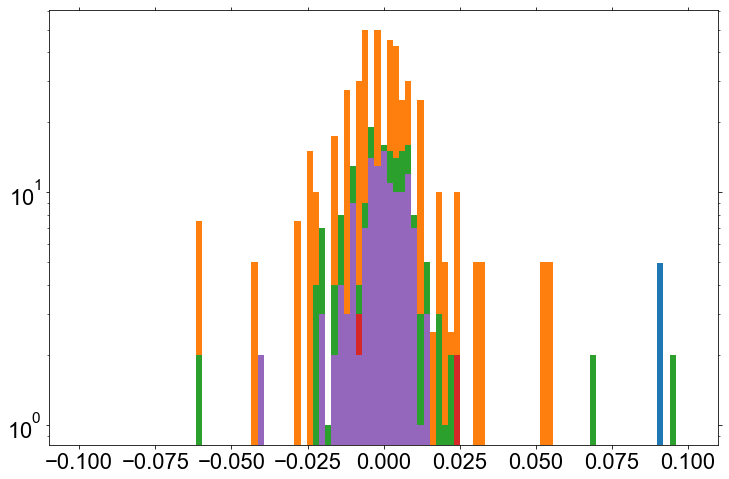

In [ ]:
# plt.hist(link_zLPU_vtx_z_info['track_delta_z'][0], label='low local z PU', bins=100, density=True, alpha=0.7)
# plt.hist(link_zLPU_vtx_z_info['track_delta_z'][11], label='high local z PU', bins=100, density=True, alpha=0.7)
# plt.legend(frameon=False)
# # plt.hist(link_zLPU_vtx_z_info['track_sigma_cut_delta_z'][idx], bins=100, density=True)
# # plt.hist(link_zLPU_vtx_z_info['vtx_delta_z'][idx]  , bins=20, density=True)

idx = 12
bins = np.linspace(-0.1, 0.1, 100)
plt.hist(link_zLPU_vtx_z_info['vtx_weighted_delta_z'][idx], bins=bins, density=True)
plt.hist(link_zLPU_vtx_z_info['vtx_sigma_cut_weighted_delta_z'][idx], bins=bins, density=True)

# plt.hist(zLPU_atheta_perf_no_link['delta_z'][idx], bins=100)
plt.hist(zLPU_athena_perf_link_req_HS['delta_z'][idx], bins=bins)
plt.hist(zLPU_athena_perf_req_clean['delta_z'][idx], bins=bins)
plt.hist(zLPU_athena_perf_req_cleanHS['delta_z'][idx], bins=bins)
# plt.hist(zLPU_atheta_perf_link_req_HS['delta_z'][idx], bins=100)
plt.yscale('log')
print(np.std(zLPU_athena_perf_link_req_HS['delta_z'][idx], ddof=1))

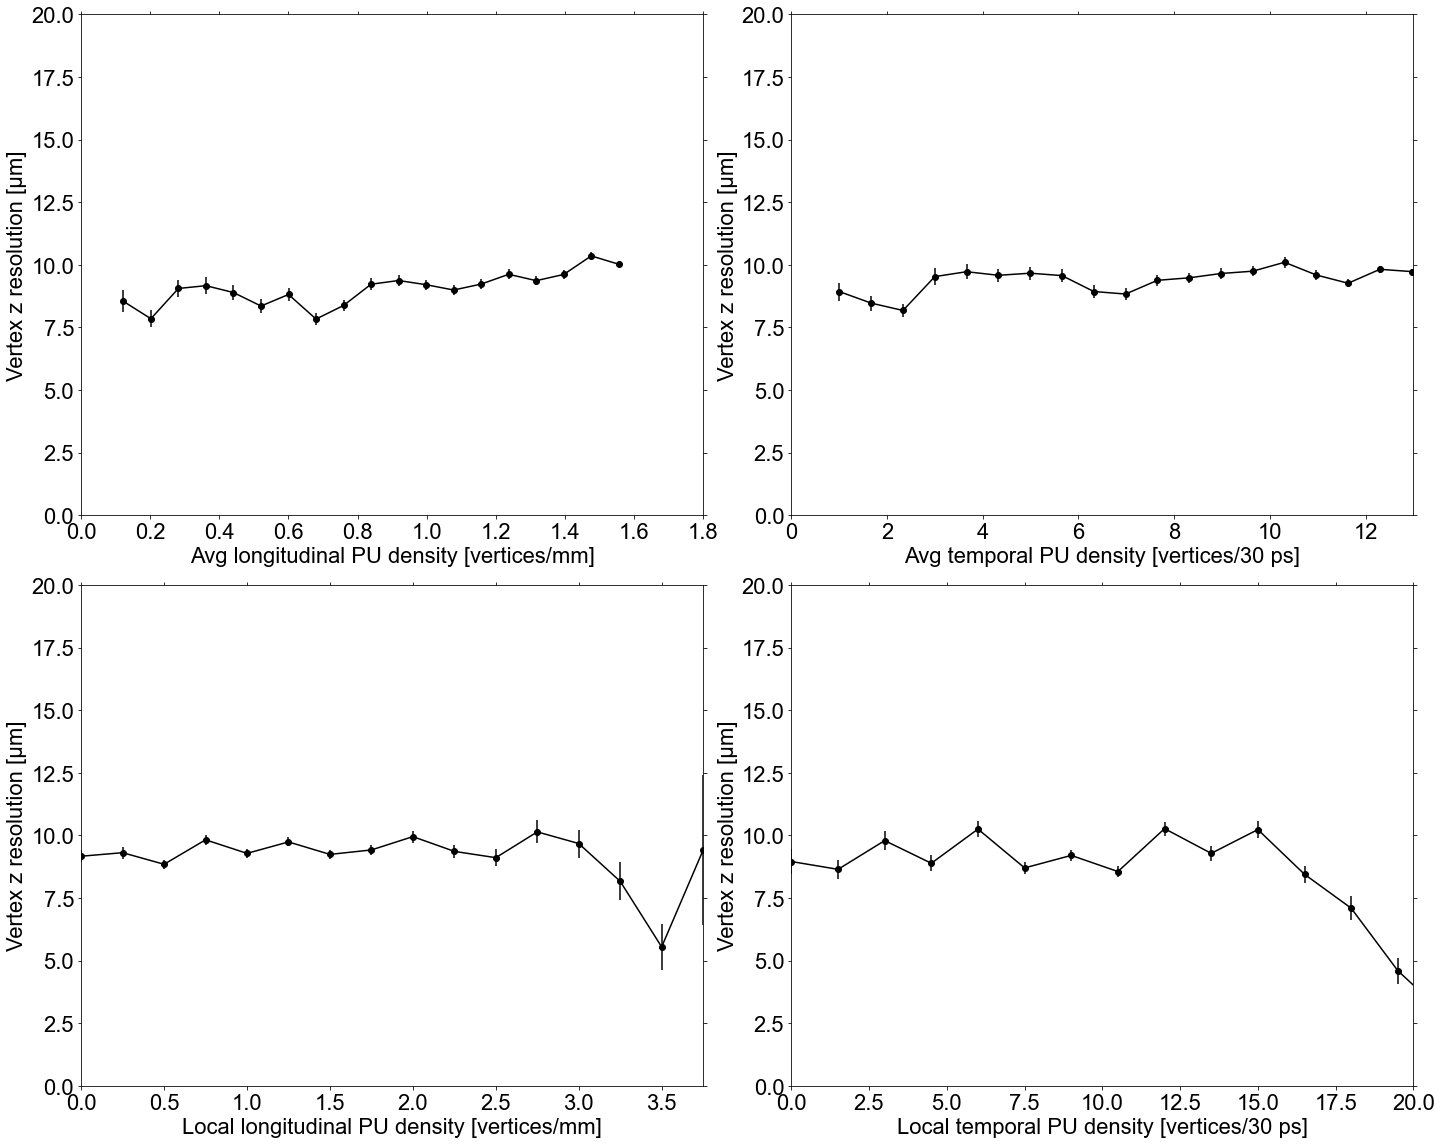

In [54]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

axes = (ax1, ax2, ax3, ax4)
all_bin_edges = (zAPU_truth_bin_edges[1:] - np.diff(zAPU_truth_bin_edges)/2, tAPU_truth_bin_edges[1:] - np.diff(tAPU_truth_bin_edges)/2, zLPU_truth_bin_edges, tLPU_truth_bin_edges)
all_link_vtx_info = (link_zAPU_vtx_z_info, link_tAPU_vtx_z_info, link_zLPU_vtx_z_info, link_tLPU_vtx_z_info)
all_athena_perf = (zAPU_athena_perf, tAPU_athena_perf, zLPU_athena_perf, tLPU_athena_perf)
all_athena_perf_req_clean = (zAPU_athena_perf_req_clean, tAPU_athena_perf_req_clean, zLPU_athena_perf_req_clean, tLPU_athena_perf_req_clean)
all_athena_perf_req_cleanHS = (zAPU_athena_perf_req_cleanHS, tAPU_athena_perf_req_cleanHS, zLPU_athena_perf_req_cleanHS, tLPU_athena_perf_req_cleanHS)
all_athena_perf_link_reqHS = (zAPU_athena_perf_link_req_HS, tAPU_athena_perf_link_req_HS, zLPU_athena_perf_link_req_HS, tLPU_athena_perf_link_req_HS)

for ax, bin_edges, link_vtx_info, athena_perf, athena_perf_req_clean, athena_perf_req_cleanHS, athena_perf_reqHS in \
    zip(axes, all_bin_edges, all_link_vtx_info, all_athena_perf, all_athena_perf_req_clean, all_athena_perf_req_cleanHS, all_athena_perf_link_reqHS):
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info['vtx_z_res']), \
    #             1e3*np.array(link_vtx_info['vtx_z_res_std']), fmt='ko-', label='Unweighted vtx z estimate')
    
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info['vtx_weighted_z_res']), \
    #             1e3*np.array(link_vtx_info['vtx_weighted_z_res_std']), fmt='go-', label='Weighted vtx z estimate')
    
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info['vtx_weight_cut_z_res']), \
                # 1e3*np.array(link_vtx_info['vtx_weight_cut_z_res_std']), fmt='bo-', label='Weight cut vtx z estimate')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info['vtx_weighted_z_res_tracks_sigma_cut']), \
    #                 1e3*np.array(link_vtx_info['vtx_weighted_z_res_std_tracks_sigma_cut']), fmt='go--', label='Weighted + sigma cut on track distribution')

    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info['vtx_sigma_cut_weighted_z_res']),\
    #                 1e3*np.array(link_vtx_info['vtx_sigma_cut_weighted_z_res_std']), fmt='ro-', label='Weighted estimator - sigma cut on vtx distr')
    
    # ax.errorbar(bin_edges, 1e3*np.array(athena_perf['delta_z_rms']), \
    #                 1e3*np.array(athena_perf['delta_z_rms_std']), fmt='k:', label='Athena performance')
    
    # ax.errorbar(bin_edges, 1e3*np.array(athena_perf_reqHS['delta_z_rms']), \
    #                 1e3*np.array(athena_perf_reqHS['delta_z_rms_std']), fmt='r:', label='Athena performance req HS')

    # ax.errorbar(bin_edges, 1e3*np.array(athena_perf_req_clean['delta_z_rms']), \
    #                 1e3*np.array(athena_perf_req_clean['delta_z_rms_std']), fmt='bo:', label='Athena performance req clean')
                    
    # ax.errorbar(bin_edges, 1e3*np.array(athena_perf_req_cleanHS['delta_z_rms']), \
    #                 1e3*np.array(athena_perf_req_cleanHS['delta_z_rms_std']), fmt='yo-', label='Athena performance req clean HS')

    
    ax.errorbar(bin_edges, 1e3*np.array(athena_perf['gaussian_std']), \
                    1e3*np.array(athena_perf['gaussian_std_std']), fmt='ko-', label='Athena performance - gauss')
    # ax.hlines(10, 0, 100, alpha=0.5)

    ax.set_ylim(0, 20)
    ax.set_ylabel('Vertex z resolution [µm]')
    # ax.legend(frameon=False)

ax1.set_xlim(0, 1.8)
ax1.set_xlabel('Avg longitudinal PU density [vertices/mm]')
ax2.set_xlim(0, 13)
ax2.set_xlabel('Avg temporal PU density [vertices/30 ps]')
ax3.set_xlim(0, 3.75)
ax3.set_xlabel('Local longitudinal PU density [vertices/mm]')
ax4.set_xlim(0, 20)
ax4.set_xlabel('Local temporal PU density [vertices/30 ps]')

fig.tight_layout()
# fig.savefig('vertex_z_res_vs_PU.pdf')

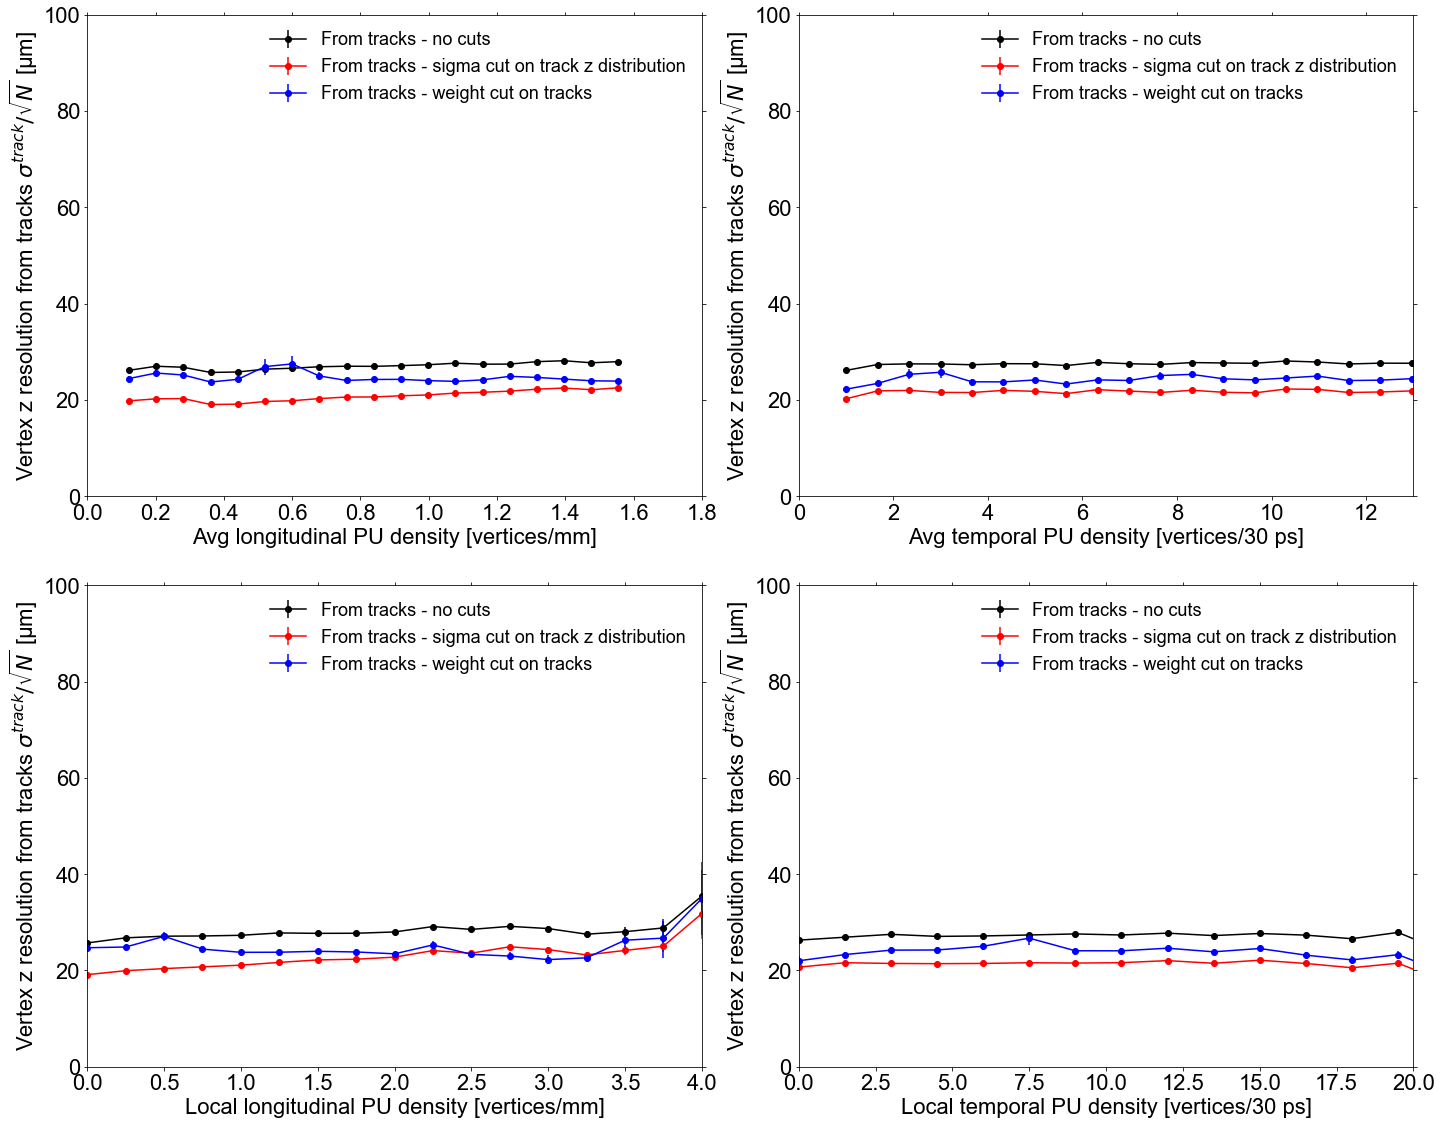

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

axes = (ax1, ax2, ax3, ax4)
all_bin_edges = (zAPU_truth_bin_edges[1:] - np.diff(zAPU_truth_bin_edges)/2, tAPU_truth_bin_edges[1:] - np.diff(tAPU_truth_bin_edges)/2, zLPU_truth_bin_edges, tLPU_truth_bin_edges)
all_link_vtx_info = (link_zAPU_vtx_z_info, link_tAPU_vtx_z_info, link_zLPU_vtx_z_info, link_tLPU_vtx_z_info)

for ax, bin_edges, link_vtx_info in zip(axes, all_bin_edges, all_link_vtx_info):
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info['track_vtx_z_res']), \
                1e3*np.array(link_vtx_info['track_vtx_z_res_std']), fmt='ko-', label='From tracks - no cuts')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info['track_vtx_z_res_sigma_cut']), \
                1e3*np.array(link_vtx_info['track_vtx_z_res_std_sigma_cut']), fmt='ro-', label='From tracks - sigma cut on track z distribution')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info['track_vtx_z_res_weight_cut']), \
                1e3*np.array(link_vtx_info['track_vtx_z_res_std_weight_cut']), fmt='bo-', label='From tracks - weight cut on tracks')

    # ax.hlines(12, 0, 100)

    ax.set_ylim(0, 100)
    ax.set_ylabel('Vertex z resolution from tracks $\\sigma^{track} / \\sqrt{N}$ [µm]')
    ax.legend(frameon=False)

ax1.set_xlim(0, 1.8)
ax1.set_xlabel('Avg longitudinal PU density [vertices/mm]')
ax2.set_xlim(0, 13)
ax2.set_xlabel('Avg temporal PU density [vertices/30 ps]')
ax3.set_xlim(0, 4)
ax3.set_xlabel('Local longitudinal PU density [vertices/mm]')
ax4.set_xlim(0, 20)
ax4.set_xlabel('Local temporal PU density [vertices/30 ps]')

fig.tight_layout()

In [ ]:
# TODO: compute the distance between truth HS and closest vtx - bin and plot resolutions vs this

In [56]:
np.average(1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res'])[:-1], weights=1/(1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_std'])[:-1])**2)

nan

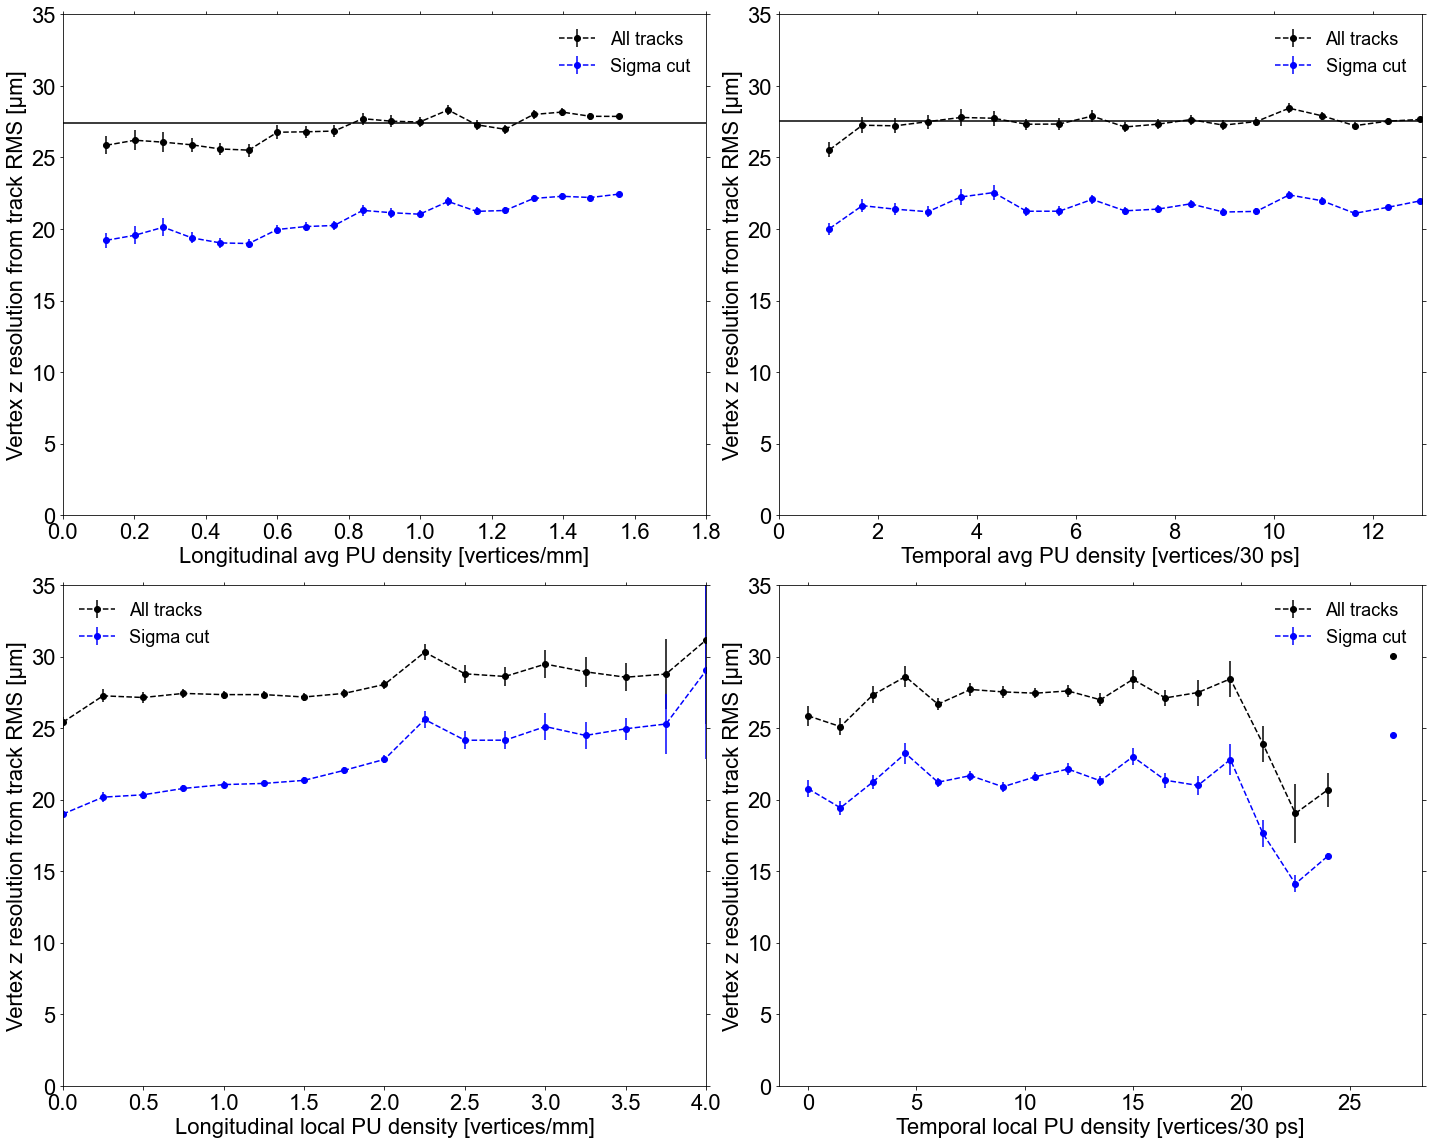

In [62]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res']),\
    1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_std']), fmt='ko--', label='All tracks')

ax1.hlines(np.average(1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res'])[1:], weights=1/(1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_std'])[1:])**2), 0, 1.8)

# ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_weight_cut']),\
#     1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_std_weight_cut']), fmt='ro--', label='Weight cut')
ax1.errorbar(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges)/2, 1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_sigma_cut']),\
    1e3*np.array(link_zAPU_vtx_z_info['track_vtx_z_res_std_sigma_cut']), fmt='bo--', label='Sigma cut')

ax1.set_xlim(0, 1.8)
ax1.set_ylim(0, 35)

ax1.set_xlabel('Longitudinal avg PU density [vertices/mm]')
ax1.set_ylabel('Vertex z resolution from track RMS [µm]')
ax1.legend(frameon=False)

ax2.errorbar(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res']),\
    1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_std']), fmt='ko--', label='All tracks')
ax2.hlines(np.average(1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res'])[1:], weights=1/(1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_std'])[1:])**2), 0, 13)

# ax2.errorbar(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_weight_cut']),\
#     1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_std_weight_cut']), fmt='ro--', label='Weight cut')
ax2.errorbar(tAPU_truth_bin_edges[1:]-np.diff(tAPU_truth_bin_edges)/2, 1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_sigma_cut']),\
    1e3*np.array(link_tAPU_vtx_z_info['track_vtx_z_res_std_sigma_cut']), fmt='bo--', label='Sigma cut')

ax2.set_xlim(0, 13)
ax2.set_ylim(0, 35)

ax2.set_xlabel('Temporal avg PU density [vertices/30 ps]')
ax2.set_ylabel('Vertex z resolution from track RMS [µm]')
ax2.legend(frameon=False)


ax3.errorbar(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_z_info['track_vtx_z_res']),\
    1e3*np.array(link_zLPU_vtx_z_info['track_vtx_z_res_std']), fmt='ko--', label='All tracks')
ax3.errorbar(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_z_info['track_vtx_z_res_sigma_cut']),\
    1e3*np.array(link_zLPU_vtx_z_info['track_vtx_z_res_std_sigma_cut']), fmt='bo--', label='Sigma cut')

ax3.set_xlim(0, 4)
ax3.set_ylim(0, 35)

ax3.set_xlabel('Longitudinal local PU density [vertices/mm]')
ax3.set_ylabel('Vertex z resolution from track RMS [µm]')
ax3.legend(frameon=False)

ax4.errorbar(tLPU_truth_bin_edges, 1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res']),\
    1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_std']), fmt='ko--', label='All tracks')
# ax4.errorbar(tLPU_truth_bin_edges, 1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_weight_cut']),\
#     1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_std_weight_cut']), fmt='ro--', label='Weight cut')
ax4.errorbar(tLPU_truth_bin_edges, 1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_sigma_cut']),\
    1e3*np.array(link_tLPU_vtx_z_info['track_vtx_z_res_std_sigma_cut']), fmt='bo--', label='Sigma cut')

# ax4.set_xlim(0, 0.7)
ax4.set_ylim(0, 35)

ax4.set_xlabel('Temporal local PU density [vertices/30 ps]')
ax4.set_ylabel('Vertex z resolution from track RMS [µm]')
ax4.legend(frameon=False)

fig.tight_layout()

Text(0.5, 0, 'Reco vtx track z - nearest truth vtx z [mm] ')

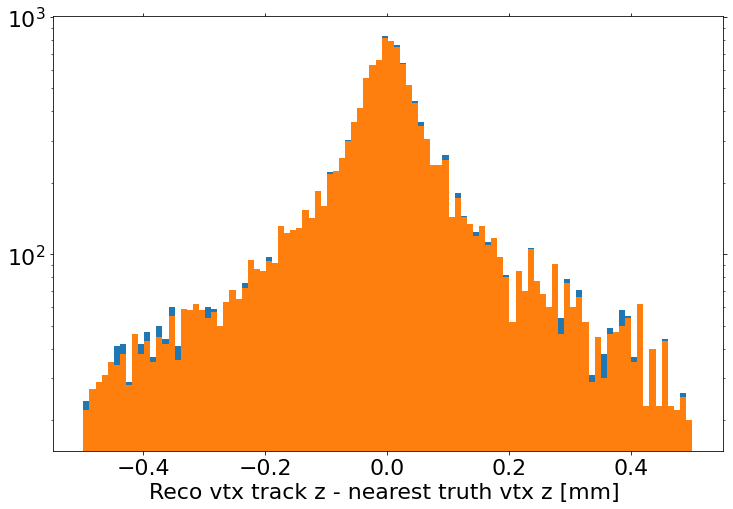

In [54]:
ct_track_delta_z_flat = np.concatenate(ct_zLPU_track_delta_z)
_  = plt.hist(ct_track_delta_z_flat[np.abs(ct_track_delta_z_flat) < 0.5], bins=100)

link_track_delta_z_flat = np.concatenate(link_zLPU_track_delta_z)
_  = plt.hist(link_track_delta_z_flat[np.abs(link_track_delta_z_flat) < 0.5], bins=100)

plt.yscale('log')
plt.xlabel('Reco vtx track z - nearest truth vtx z [mm] ')

In [ ]:
# fit core of gaussian
# plot sigma and rms
# see delta z w/o cut

# vertex z from avg track z w and w/o cut  

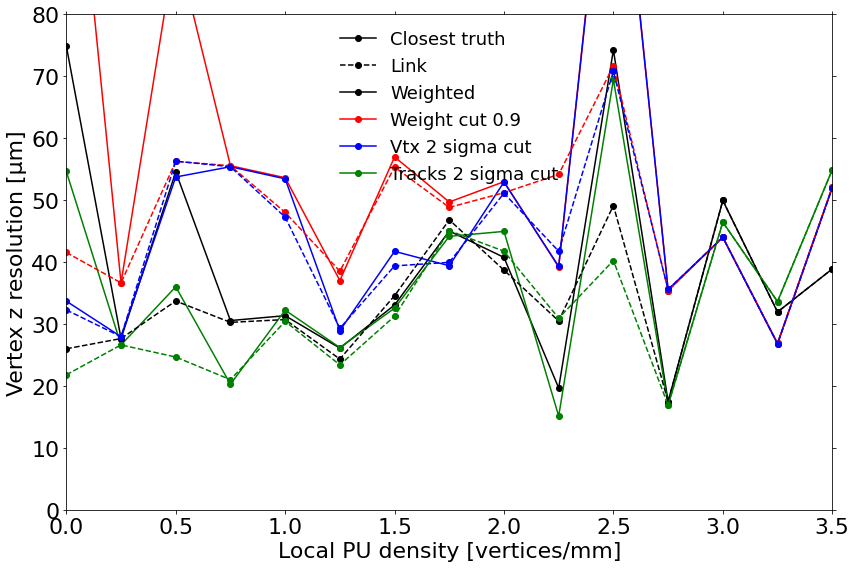

In [89]:
plt.plot([], [], 'ko-', label='Closest truth')
plt.plot([], [], 'ko--', label='Link')

plt.plot(zLPU_truth_bin_edges, 1e3*np.array(ct_zLPU_vtx_weighted_z_res), 'ko-', label='Weighted')
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(ct_zLPU_vtx_weight_cut_z_res), 'ro-', label='Weight cut {}'.format(0.9))
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(ct_zLPU_vtx_sigma_cut_weighted_z_res), 'bo-', label='Vtx {} sigma cut'.format(2))
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(ct_zLPU_vtx_weighted_z_res_tracks_sigma_cut), 'go-', label='Tracks {} sigma cut'.format(2))

plt.plot(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_weighted_z_res), 'ko--')
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_weight_cut_z_res), 'ro--')
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_sigma_cut_weighted_z_res), 'bo--')
plt.plot(zLPU_truth_bin_edges, 1e3*np.array(link_zLPU_vtx_weighted_z_res_tracks_sigma_cut), 'go--')



plt.xlim(0, 3.5)
plt.ylim(0, 80)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex z resolution [µm]')
plt.legend(frameon=False)
plt.tight_layout()

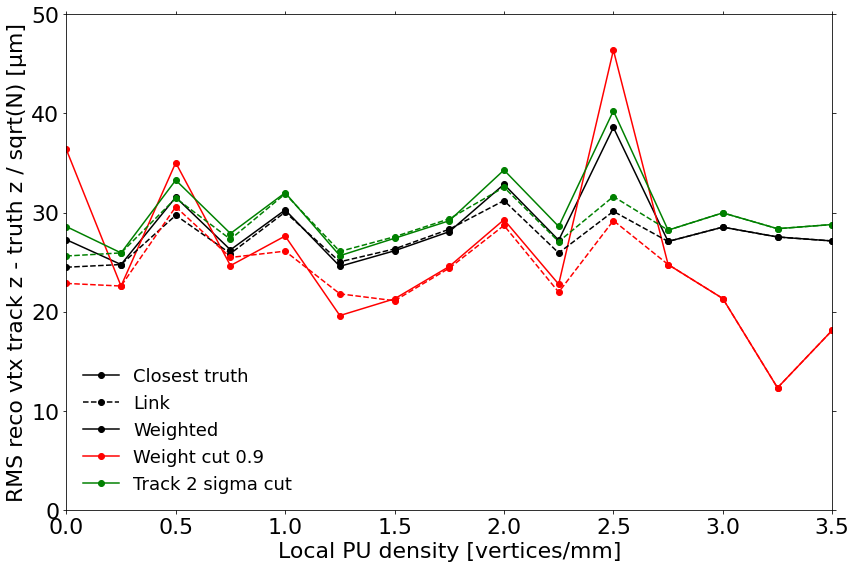

In [14]:
plt.plot([], [], 'ko-', label='Closest truth')
plt.plot([], [], 'ko--', label='Link')
plt.plot(truth_bin_edges, 1e3*np.array(ct_track_vtx_z_res), 'ko-', label='Weighted')
plt.plot(truth_bin_edges, 1e3*np.array(ct_track_vtx_z_res_weight_cut), 'ro-', label='Weight cut {}'.format(0.9))
plt.plot(truth_bin_edges, 1e3*np.array(ct_track_vtx_z_res_sigma_cut), 'go-', label='Track {} sigma cut'.format(2))

plt.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_z_res), 'ko--')
plt.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_z_res_weight_cut), 'ro--')
plt.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_z_res_sigma_cut), 'go--')


plt.xlim(0, 3.5)
plt.ylim(0, 50)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('RMS reco vtx track z - truth z / sqrt(N) [µm]')
plt.legend(frameon=False)
plt.tight_layout()

In [15]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_vtx_z_weighted_res), 'ko-', label='Unweighted')
# plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_vtx_z_res), 'bo-', label='Weighted avg')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_localPU_bins_w_cut_vtx_z_res), 'ro-', label='Weight cut {}'.format(w_cut))


plt.xlim(0, 3.5)
# plt.ylim(0, 50)

plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('RMS reco vtx track z - truth z / sqrt(N) [µm]')
plt.legend(frameon=False)

NameError: name 'closest_truth_localPU_bins_vtx_z_weighted_res' is not defined

In [ ]:
# resolution vs distance to the closest truth vertex
# split into different eta regions

In [205]:
track_z0_var_recoHS = np.array([])
track_z0_var_truthHS = np.array([])
for idx in range(len(reco_vertex_track_idxs)):
    track_z0_var_recoHS = np.concatenate((track_z0_var_recoHS, track_z0_var[idx][reco_vertex_track_idxs[idx][0]]))
    track_z0_var_truthHS = np.concatenate((track_z0_var_truthHS, track_z0_var[idx][truth_vertex_track_idxs[idx][0]]))

Text(0.5, 0, 'track sigma_z0 [mm]')

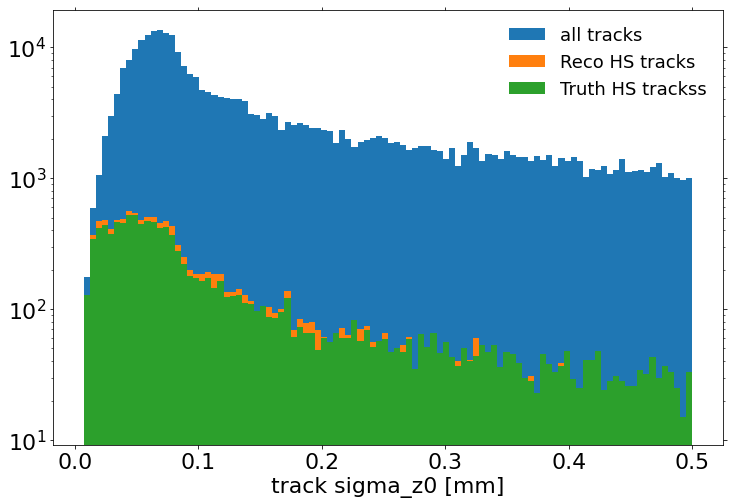

In [210]:
max_sigma = 0.5**2
_ = plt.hist(np.concatenate(track_z0_var)[np.concatenate(track_z0_var) < max_sigma]**0.5, bins=100, label='all tracks')
_ = plt.hist(track_z0_var_recoHS[track_z0_var_recoHS < max_sigma]**0.5, bins=100, label='Reco HS tracks')
_ = plt.hist(track_z0_var_truthHS[track_z0_var_truthHS < max_sigma]**0.5, bins=100, label='Truth HS trackss')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('track sigma_z0 [mm]')

In [ ]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))
    
closest_truth_localPU_bins_delta_zs = []
closest_truth_localPU_bins_delta_z_rms_all = []
closest_truth_localPU_bins_vtx_z_res = []

closest_truth_localPU_bins_delta_z_weighted_rms_all = []
closest_truth_localPU_bins_vtx_z_weighted_res = []

w_cut = 0.9

closest_truth_localPU_bins_w_cut_delta_zs = []
closest_truth_localPU_bins_w_cut_delta_z_rms_all = []
closest_truth_localPU_bins_w_cut_vtx_z_res = []

for event_idxs in events_in_PU_bins:
    
    bin_closest_truth_delta_zs = np.array([])
    bin_closest_truth_delta_z_rms = []
    bin_closest_truth_delta_z_weighted_rms = []
    bin_closest_truth_n_tracks = []
    
    bin_closest_truth_w_cut_delta_zs = np.array([])
    bin_closest_truth_w_cut_delta_z_rms = []
    bin_closest_truth_w_cut_n_tracks = []
    
    for event_idx in event_idxs:
        event_idx = event_idx[0]
        reco_track_weights = reco_vertex_track_weights[event_idx][0]
        
        reco_vtx_z = reco_vertex_z[event_idx][0]
        closest_truth_z = truth_vertex_z[event_idx][np.argmin(np.abs(truth_vertex_z[event_idx] - reco_vtx_z))]
        
        delta_zs = track_z0[event_idx][reco_vertex_track_idxs[event_idx][0]] - closest_truth_z

        bin_closest_truth_delta_zs = np.concatenate((bin_closest_truth_delta_zs, delta_zs))
        bin_closest_truth_delta_z_rms.append(np.sqrt(np.mean(delta_zs**2)))
        bin_closest_truth_delta_z_weighted_rms.append(np.sqrt(np.average(delta_zs**2, weights=reco_track_weights)))
        bin_closest_truth_n_tracks.append(len(delta_zs))
        
        cut_idx = np.array(reco_track_weights) > w_cut
        bin_closest_truth_w_cut_delta_zs = np.concatenate((bin_closest_truth_delta_zs, delta_zs[cut_idx]))
        bin_closest_truth_w_cut_delta_z_rms.append(np.sqrt(np.average(delta_zs[cut_idx]**2)))
        bin_closest_truth_w_cut_n_tracks.append(len(delta_zs[cut_idx]))
        
    closest_truth_localPU_bins_delta_zs.append(bin_closest_truth_delta_zs)
    closest_truth_localPU_bins_delta_z_rms_all.append(bin_closest_truth_delta_z_rms)
    closest_truth_localPU_bins_vtx_z_res.append(np.mean(bin_closest_truth_delta_z_rms / np.sqrt(np.array(bin_closest_truth_n_tracks))))
    closest_truth_localPU_bins_delta_z_weighted_rms_all.append(bin_closest_truth_delta_z_weighted_rms)
    closest_truth_localPU_bins_vtx_z_weighted_res.append(np.mean(bin_closest_truth_delta_z_weighted_rms / np.sqrt(np.array(bin_closest_truth_n_tracks))))
    
    closest_truth_localPU_bins_w_cut_delta_zs.append(bin_closest_truth_w_cut_delta_zs)
    closest_truth_localPU_bins_w_cut_delta_z_rms_all.append(bin_closest_truth_w_cut_delta_z_rms)
    closest_truth_localPU_bins_w_cut_vtx_z_res.append(np.nanmean(bin_closest_truth_w_cut_delta_z_rms / np.sqrt(np.array(bin_closest_truth_w_cut_n_tracks))))